In [24]:
from datetime import datetime
import time
from collections import namedtuple
import seaborn as sns; 
sns.set(style="ticks", color_codes=True)
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_fscore_support
#now = datetime.utcnow().strftime("% Y% m% d% H% M% S")
root_logdir = "tf_logs"
#logdir = "{}/ run-{}/".format( root_logdir, now)

###### IMPORTING THE FASHION TEST AND TRAINING DATA INTO DATASET

In [25]:
training_file = 'fashionmnist/fashion-mnist_train.csv'
test_file = 'fashionmnist/fashion-mnist_test.csv'
train_df = pd.read_csv(training_file)
test_df = pd.read_csv(test_file)
# train_df.head(10)
train_ds = train_df.values
test_ds = test_df.values
train_ds_X = train_ds[:,1:]
test_ds_X = test_ds[:,1:]
train_ds_Y = train_ds[:,:1]
test_ds_Y = test_ds[:,:1]
train_ds_X_rc = train_ds_X.reshape(-1,28,28)
test_ds_X_rc = test_ds_X.reshape(-1,28,28)
train_ds_X_shape = train_ds_X.reshape(-1,28,28,1)
test_ds_X_val = test_ds_X_rc.reshape(-1,28,28,1)

###### DISPLAY IT INTO IMAGES

In [47]:
%matplotlib inline

label_classes = ['top','trouser','pullover','dress','coat','sandal','shirt','sneaker','bag','boot']
def show_image(search_index, X_set, Y_set):
    #search_index = 12343
    from matplotlib import pyplot as plt
    print("IMAGE TYPE:", label_classes[Y_set[search_index][0]])
    plt.imshow(X_set[search_index], interpolation='gaussian', cmap="gray")
    plt.show()

IMAGE TYPE: pullover


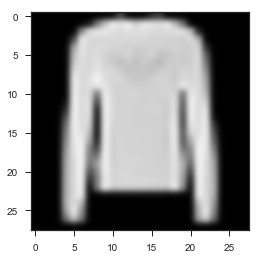

In [27]:
show_image(18333, train_ds_X_rc, train_ds_Y)

###### NORMALIZE AND ONE HOT CODE

In [28]:
def one_hot_encode(x, n_classes):
    return np.eye(n_classes)[x.reshape(-1)]

def normalize(train_ds_X):
    norm_func = lambda t: t / 256
    vfunc = np.vectorize(norm_func)
    return vfunc(train_ds_X)
train_ds_X_shape = normalize(train_ds_X_shape)
train_ds_Y = one_hot_encode(train_ds_Y,10)
test_ds_X_shape = normalize(test_ds_X_val)
test_ds_Y_temp = test_ds_Y
test_ds_Y = one_hot_encode(test_ds_Y,10)

In [29]:

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def get_data_batches(batch_size = 128):
    X, Y = unison_shuffled_copies(train_ds_X_shape, train_ds_Y)
    number_batches = int(len(X)/batch_size)
    x_batches = np.array(np.array_split(X, number_batches))
    y_batches = np.array(np.array_split(Y, number_batches))
    return x_batches,y_batches

In [30]:
xx, yy = get_data_batches(64)
print(xx.shape)

(937,)


###### BUILD THE CNN MODEL

###### BASIC INPUTS

In [31]:
def neural_net_image_input(image_shape):
    return tf.placeholder(tf.float32, shape=(None,) + image_shape , name="x")


def neural_net_label_input(n_classes):
    return tf.placeholder(tf.float32, shape=(None,n_classes) , name="y")


def neural_net_keep_prob_input():
    return tf.placeholder(tf.float32, name="keep_prob")

###### CONV LAYER WITH MAX POOLING

In [32]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    
    # Output depth
    k_output = conv_num_outputs
    
    input_shape = x_tensor.get_shape().as_list()

    # Image Properties
    image_width = input_shape[1]
    image_height = input_shape[2]
    color_channels = input_shape[3]

    # Convolution filter
    filter_size_width = conv_ksize[0]
    filter_size_height = conv_ksize[1]
    
    
    # Weight and bias
    weight = tf.Variable(tf.truncated_normal(
        [filter_size_height, filter_size_width, color_channels, k_output]))
    bias = tf.Variable(tf.zeros(k_output))
    
    #weight should be propotional to filter size
    conv_layer = tf.nn.conv2d(x_tensor, weight, strides=[1,conv_strides[0],conv_strides[1],1], padding='SAME')
    
    # Add bias
    conv_layer = tf.nn.bias_add(conv_layer, bias)
    
    # Apply activation function
    
    conv_layer = tf.nn.relu(conv_layer)
    
    #Adding max pooling layer to it
    
    return tf.nn.max_pool(
        conv_layer,
        ksize=[1, pool_ksize[0], pool_ksize[1], 1],
        strides=[1, pool_strides[0],pool_strides[1], 1],
        padding='SAME')

###### FLATTEN LAYER TO CONVERT 4D TO 2D (NUMBER BATCHES, FLATENNED DIMENSIONS)

In [33]:
def flatten(x_tensor):
    return tf.contrib.layers.flatten(x_tensor)

###### FULLY CONNECTED DENSE LAYER WITH RELU ACTIVATION

In [34]:
def fully_conn(x_tensor, num_outputs):
    return tf.contrib.layers.fully_connected(x_tensor, num_outputs)


###### OUTPUT A SIMPLE DENSE LAYER

In [35]:
def output(x_tensor, num_outputs):
    return tf.layers.dense(inputs=x_tensor, units=num_outputs)

###### BUILDING THE CONV NET

In [36]:
def conv_net(x, keep_prob):
    # Currently we have two Fully Connected and one conv,(TODO: Try atleast 2 conv layers)
    # Function Definition from Above:
    #    conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
        
    #Parameters input, conv net dimensions, filter sizes, stride dimensions, pool size, pool stride
    conv_output = conv2d_maxpool(x, 10, (4,4), (2,2), (2,2), (2,2))
    
    conv_output = conv2d_maxpool(conv_output, 30, (2,2), (1,1), (1,1), (1,1))

    # Apply a Flatten Layer
    # Function Definition from Above:
    flattened_output = flatten(conv_output)
    
    # Apply 1, 2, or 3 Fully Connected Layers
    #    Play around with different number of outputs
    # Function Definition from Above:
    fully_con_output = fully_conn(flattened_output, 256)
    # Adding a drop out layer
    fully_con_output = tf.nn.dropout(fully_con_output, keep_prob)
    # Adding another layer
    
    fully_con_output = fully_conn(fully_con_output, 64)
    # Adding a drop out layer
    fully_con_output = tf.nn.dropout(fully_con_output, keep_prob)
    
    fully_con_output = fully_conn(fully_con_output, 32)
      
    #Apply an Output Layer
    #    Set this to the number of classes
    # Function Definition from Above:
    final_output = output(fully_con_output, 10)
    
    return final_output

In [37]:
# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((28, 28, 1))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)
# Save logits with a particular name to use later
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
learning_rate=0.01
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')


saver = tf.train.Saver()

###### FUNCTION TO PRINT STATS

In [38]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    # Calculate batch loss and accuracy
    loss = session.run(cost, feed_dict={
        x: feature_batch,
        y: label_batch,
        keep_prob: 1.})
    valid_acc = sess.run(accuracy, feed_dict={
        x: test_ds_X_shape,
        y: test_ds_Y,
        keep_prob: 1.})
    print("Loss in this Epoch is:",loss * 100,"%")
    print("Accuracy in this Epoch is:",valid_acc * 100, "%")

###### RUN NEURAL NETWORK

In [39]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    session.run(optimizer, feed_dict={
        x: feature_batch,
        y: label_batch,
    keep_prob: keep_probability})

###### HYPER PARAMETERS

In [40]:
#  Tune Parameters
epochs = 100
batch_size = 256
keep_probability = 0.8

###### TRAIN THE MODEL

In [41]:
print('Checking the Training on a Single Batch...')
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    x_batches, y_batches = get_data_batches(batch_size)
    train_neural_network(sess, optimizer, keep_probability, x_batches[0], y_batches[0])
    print_stats(sess, x_batches[0], y_batches[0], cost, accuracy)
    # Training cycle
    for epoch in range(epochs):
        batch_features, batch_labels = get_data_batches(batch_size)
        for batch_num in range(len(batch_features)):
            train_neural_network(sess, optimizer, keep_probability, batch_features[batch_num], batch_labels[batch_num])
            loss = sess.run(cost, feed_dict={
                x: batch_features[batch_num],
                y: batch_labels[batch_num],
                keep_prob: 1.})
            print('Epoch {:>2}, Batch {} Loss:{}'.format(epoch + 1, batch_num, loss))
        save_path = saver.save(sess, "model.ckpt/")
        print_stats(sess, batch_features[-1], batch_labels[-1], cost, accuracy)
        

Checking the Training on a Single Batch...
Loss in this Epoch is: 2991.8718338 %
Accuracy in this Epoch is: 10.0199997425 %
Epoch  1, Batch 0 Loss:36.02619552612305
Epoch  1, Batch 1 Loss:41.6101188659668
Epoch  1, Batch 2 Loss:13.77192211151123
Epoch  1, Batch 3 Loss:14.487677574157715
Epoch  1, Batch 4 Loss:7.796380519866943
Epoch  1, Batch 5 Loss:5.611401557922363
Epoch  1, Batch 6 Loss:3.841770648956299
Epoch  1, Batch 7 Loss:2.282883405685425
Epoch  1, Batch 8 Loss:2.131594657897949
Epoch  1, Batch 9 Loss:2.280226707458496
Epoch  1, Batch 10 Loss:2.2855727672576904
Epoch  1, Batch 11 Loss:2.2554609775543213
Epoch  1, Batch 12 Loss:2.249281644821167
Epoch  1, Batch 13 Loss:2.1587979793548584
Epoch  1, Batch 14 Loss:2.1258506774902344
Epoch  1, Batch 15 Loss:2.0968050956726074
Epoch  1, Batch 16 Loss:2.049468994140625
Epoch  1, Batch 17 Loss:2.001471519470215
Epoch  1, Batch 18 Loss:1.9455558061599731
Epoch  1, Batch 19 Loss:1.9040807485580444
Epoch  1, Batch 20 Loss:1.8754212856292

Epoch  1, Batch 205 Loss:0.4283589720726013
Epoch  1, Batch 206 Loss:0.46041569113731384
Epoch  1, Batch 207 Loss:0.4709938168525696
Epoch  1, Batch 208 Loss:0.6023461818695068
Epoch  1, Batch 209 Loss:0.45217961072921753
Epoch  1, Batch 210 Loss:0.47561293840408325
Epoch  1, Batch 211 Loss:0.47601500153541565
Epoch  1, Batch 212 Loss:0.5658949017524719
Epoch  1, Batch 213 Loss:0.560224711894989
Epoch  1, Batch 214 Loss:0.5398871898651123
Epoch  1, Batch 215 Loss:0.3970404267311096
Epoch  1, Batch 216 Loss:0.4614701271057129
Epoch  1, Batch 217 Loss:0.5283806324005127
Epoch  1, Batch 218 Loss:0.4609920084476471
Epoch  1, Batch 219 Loss:0.4916534721851349
Epoch  1, Batch 220 Loss:0.5477521419525146
Epoch  1, Batch 221 Loss:0.4467812478542328
Epoch  1, Batch 222 Loss:0.5504601001739502
Epoch  1, Batch 223 Loss:0.48503589630126953
Epoch  1, Batch 224 Loss:0.5067518353462219
Epoch  1, Batch 225 Loss:0.49093037843704224
Epoch  1, Batch 226 Loss:0.4858595132827759
Epoch  1, Batch 227 Loss:0.

Epoch  2, Batch 158 Loss:0.5051558613777161
Epoch  2, Batch 159 Loss:0.49281251430511475
Epoch  2, Batch 160 Loss:0.43258345127105713
Epoch  2, Batch 161 Loss:0.3785262703895569
Epoch  2, Batch 162 Loss:0.3430890440940857
Epoch  2, Batch 163 Loss:0.3134452998638153
Epoch  2, Batch 164 Loss:0.434594064950943
Epoch  2, Batch 165 Loss:0.40330326557159424
Epoch  2, Batch 166 Loss:0.5023763179779053
Epoch  2, Batch 167 Loss:0.36229756474494934
Epoch  2, Batch 168 Loss:0.3525986671447754
Epoch  2, Batch 169 Loss:0.4127746820449829
Epoch  2, Batch 170 Loss:0.3816092014312744
Epoch  2, Batch 171 Loss:0.32653889060020447
Epoch  2, Batch 172 Loss:0.48104819655418396
Epoch  2, Batch 173 Loss:0.40808799862861633
Epoch  2, Batch 174 Loss:0.457528680562973
Epoch  2, Batch 175 Loss:0.4568202793598175
Epoch  2, Batch 176 Loss:0.45863670110702515
Epoch  2, Batch 177 Loss:0.42263469099998474
Epoch  2, Batch 178 Loss:0.35241127014160156
Epoch  2, Batch 179 Loss:0.41034066677093506
Epoch  2, Batch 180 Los

Epoch  3, Batch 127 Loss:0.314226895570755
Epoch  3, Batch 128 Loss:0.28565797209739685
Epoch  3, Batch 129 Loss:0.40243586897850037
Epoch  3, Batch 130 Loss:0.30170655250549316
Epoch  3, Batch 131 Loss:0.39427515864372253
Epoch  3, Batch 132 Loss:0.3905499577522278
Epoch  3, Batch 133 Loss:0.35935068130493164
Epoch  3, Batch 134 Loss:0.4410388171672821
Epoch  3, Batch 135 Loss:0.43861669301986694
Epoch  3, Batch 136 Loss:0.33593329787254333
Epoch  3, Batch 137 Loss:0.38006699085235596
Epoch  3, Batch 138 Loss:0.3724534213542938
Epoch  3, Batch 139 Loss:0.3593045175075531
Epoch  3, Batch 140 Loss:0.4358416199684143
Epoch  3, Batch 141 Loss:0.35423266887664795
Epoch  3, Batch 142 Loss:0.44293323159217834
Epoch  3, Batch 143 Loss:0.3555206060409546
Epoch  3, Batch 144 Loss:0.39980387687683105
Epoch  3, Batch 145 Loss:0.3338574171066284
Epoch  3, Batch 146 Loss:0.35443535447120667
Epoch  3, Batch 147 Loss:0.32933974266052246
Epoch  3, Batch 148 Loss:0.3361542820930481
Epoch  3, Batch 149 

Epoch  4, Batch 84 Loss:0.33697709441185
Epoch  4, Batch 85 Loss:0.37679654359817505
Epoch  4, Batch 86 Loss:0.31826382875442505
Epoch  4, Batch 87 Loss:0.2870209813117981
Epoch  4, Batch 88 Loss:0.35207435488700867
Epoch  4, Batch 89 Loss:0.3496813178062439
Epoch  4, Batch 90 Loss:0.35140132904052734
Epoch  4, Batch 91 Loss:0.45398858189582825
Epoch  4, Batch 92 Loss:0.32141974568367004
Epoch  4, Batch 93 Loss:0.34361377358436584
Epoch  4, Batch 94 Loss:0.33824747800827026
Epoch  4, Batch 95 Loss:0.36262136697769165
Epoch  4, Batch 96 Loss:0.27106472849845886
Epoch  4, Batch 97 Loss:0.30643463134765625
Epoch  4, Batch 98 Loss:0.32032129168510437
Epoch  4, Batch 99 Loss:0.3050723075866699
Epoch  4, Batch 100 Loss:0.3472745418548584
Epoch  4, Batch 101 Loss:0.31436437368392944
Epoch  4, Batch 102 Loss:0.3140263855457306
Epoch  4, Batch 103 Loss:0.31823551654815674
Epoch  4, Batch 104 Loss:0.38718128204345703
Epoch  4, Batch 105 Loss:0.28765028715133667
Epoch  4, Batch 106 Loss:0.3006573

Epoch  5, Batch 39 Loss:0.31982219219207764
Epoch  5, Batch 40 Loss:0.22580021619796753
Epoch  5, Batch 41 Loss:0.20740772783756256
Epoch  5, Batch 42 Loss:0.19468553364276886
Epoch  5, Batch 43 Loss:0.30523213744163513
Epoch  5, Batch 44 Loss:0.2879759669303894
Epoch  5, Batch 45 Loss:0.3175240755081177
Epoch  5, Batch 46 Loss:0.28189605474472046
Epoch  5, Batch 47 Loss:0.36323976516723633
Epoch  5, Batch 48 Loss:0.25058773159980774
Epoch  5, Batch 49 Loss:0.22223569452762604
Epoch  5, Batch 50 Loss:0.3312514126300812
Epoch  5, Batch 51 Loss:0.3811187744140625
Epoch  5, Batch 52 Loss:0.2834217846393585
Epoch  5, Batch 53 Loss:0.4239254295825958
Epoch  5, Batch 54 Loss:0.27523672580718994
Epoch  5, Batch 55 Loss:0.2832024395465851
Epoch  5, Batch 56 Loss:0.3374984860420227
Epoch  5, Batch 57 Loss:0.3083328604698181
Epoch  5, Batch 58 Loss:0.311026930809021
Epoch  5, Batch 59 Loss:0.3093146085739136
Epoch  5, Batch 60 Loss:0.22990165650844574
Epoch  5, Batch 61 Loss:0.3214211165904999
E

Loss in this Epoch is: 29.7423452139 %
Accuracy in this Epoch is: 86.8200004101 %
Epoch  6, Batch 0 Loss:0.33476880192756653
Epoch  6, Batch 1 Loss:0.2874200642108917
Epoch  6, Batch 2 Loss:0.23507258296012878
Epoch  6, Batch 3 Loss:0.26037120819091797
Epoch  6, Batch 4 Loss:0.3269757926464081
Epoch  6, Batch 5 Loss:0.34711599349975586
Epoch  6, Batch 6 Loss:0.41340821981430054
Epoch  6, Batch 7 Loss:0.3306151032447815
Epoch  6, Batch 8 Loss:0.37398862838745117
Epoch  6, Batch 9 Loss:0.2775023877620697
Epoch  6, Batch 10 Loss:0.2473011016845703
Epoch  6, Batch 11 Loss:0.2850324809551239
Epoch  6, Batch 12 Loss:0.3559550940990448
Epoch  6, Batch 13 Loss:0.3102570176124573
Epoch  6, Batch 14 Loss:0.3197363615036011
Epoch  6, Batch 15 Loss:0.3078502118587494
Epoch  6, Batch 16 Loss:0.33513888716697693
Epoch  6, Batch 17 Loss:0.2668616473674774
Epoch  6, Batch 18 Loss:0.31821587681770325
Epoch  6, Batch 19 Loss:0.2903807461261749
Epoch  6, Batch 20 Loss:0.29556241631507874
Epoch  6, Batch 

Epoch  6, Batch 199 Loss:0.31652870774269104
Epoch  6, Batch 200 Loss:0.3074321746826172
Epoch  6, Batch 201 Loss:0.2957015633583069
Epoch  6, Batch 202 Loss:0.2627895176410675
Epoch  6, Batch 203 Loss:0.3170918822288513
Epoch  6, Batch 204 Loss:0.2652716040611267
Epoch  6, Batch 205 Loss:0.29773855209350586
Epoch  6, Batch 206 Loss:0.2919335663318634
Epoch  6, Batch 207 Loss:0.3019575774669647
Epoch  6, Batch 208 Loss:0.3322961926460266
Epoch  6, Batch 209 Loss:0.24820519983768463
Epoch  6, Batch 210 Loss:0.3156859576702118
Epoch  6, Batch 211 Loss:0.24858608841896057
Epoch  6, Batch 212 Loss:0.31212085485458374
Epoch  6, Batch 213 Loss:0.37885940074920654
Epoch  6, Batch 214 Loss:0.25705671310424805
Epoch  6, Batch 215 Loss:0.3007018566131592
Epoch  6, Batch 216 Loss:0.28807276487350464
Epoch  6, Batch 217 Loss:0.3259166479110718
Epoch  6, Batch 218 Loss:0.28957217931747437
Epoch  6, Batch 219 Loss:0.2835542559623718
Epoch  6, Batch 220 Loss:0.26501742005348206
Epoch  6, Batch 221 Lo

Epoch  7, Batch 178 Loss:0.2839789092540741
Epoch  7, Batch 179 Loss:0.26334309577941895
Epoch  7, Batch 180 Loss:0.28502804040908813
Epoch  7, Batch 181 Loss:0.2588793635368347
Epoch  7, Batch 182 Loss:0.2879922389984131
Epoch  7, Batch 183 Loss:0.2852274179458618
Epoch  7, Batch 184 Loss:0.32233697175979614
Epoch  7, Batch 185 Loss:0.2864565849304199
Epoch  7, Batch 186 Loss:0.31898826360702515
Epoch  7, Batch 187 Loss:0.29390859603881836
Epoch  7, Batch 188 Loss:0.29566147923469543
Epoch  7, Batch 189 Loss:0.29798048734664917
Epoch  7, Batch 190 Loss:0.29124915599823
Epoch  7, Batch 191 Loss:0.2399696409702301
Epoch  7, Batch 192 Loss:0.2377997487783432
Epoch  7, Batch 193 Loss:0.3351513147354126
Epoch  7, Batch 194 Loss:0.2685364782810211
Epoch  7, Batch 195 Loss:0.29965025186538696
Epoch  7, Batch 196 Loss:0.32425063848495483
Epoch  7, Batch 197 Loss:0.20360371470451355
Epoch  7, Batch 198 Loss:0.2310599982738495
Epoch  7, Batch 199 Loss:0.2133219987154007
Epoch  7, Batch 200 Loss

Epoch  8, Batch 145 Loss:0.2512893080711365
Epoch  8, Batch 146 Loss:0.2536024749279022
Epoch  8, Batch 147 Loss:0.2702682912349701
Epoch  8, Batch 148 Loss:0.35446351766586304
Epoch  8, Batch 149 Loss:0.24413719773292542
Epoch  8, Batch 150 Loss:0.256472647190094
Epoch  8, Batch 151 Loss:0.23447160422801971
Epoch  8, Batch 152 Loss:0.30130666494369507
Epoch  8, Batch 153 Loss:0.3031542897224426
Epoch  8, Batch 154 Loss:0.26423919200897217
Epoch  8, Batch 155 Loss:0.2010030895471573
Epoch  8, Batch 156 Loss:0.3182887136936188
Epoch  8, Batch 157 Loss:0.23067210614681244
Epoch  8, Batch 158 Loss:0.1925962269306183
Epoch  8, Batch 159 Loss:0.28386831283569336
Epoch  8, Batch 160 Loss:0.3156428039073944
Epoch  8, Batch 161 Loss:0.23642374575138092
Epoch  8, Batch 162 Loss:0.27212563157081604
Epoch  8, Batch 163 Loss:0.28685861825942993
Epoch  8, Batch 164 Loss:0.26204726099967957
Epoch  8, Batch 165 Loss:0.3017396330833435
Epoch  8, Batch 166 Loss:0.295919269323349
Epoch  8, Batch 167 Los

Epoch  9, Batch 121 Loss:0.22295306622982025
Epoch  9, Batch 122 Loss:0.25826209783554077
Epoch  9, Batch 123 Loss:0.2033987045288086
Epoch  9, Batch 124 Loss:0.2724262475967407
Epoch  9, Batch 125 Loss:0.21705031394958496
Epoch  9, Batch 126 Loss:0.22993741929531097
Epoch  9, Batch 127 Loss:0.17156982421875
Epoch  9, Batch 128 Loss:0.2624654471874237
Epoch  9, Batch 129 Loss:0.3007252812385559
Epoch  9, Batch 130 Loss:0.2313479483127594
Epoch  9, Batch 131 Loss:0.24863608181476593
Epoch  9, Batch 132 Loss:0.3216108977794647
Epoch  9, Batch 133 Loss:0.28340044617652893
Epoch  9, Batch 134 Loss:0.3044946789741516
Epoch  9, Batch 135 Loss:0.2685471177101135
Epoch  9, Batch 136 Loss:0.20726069808006287
Epoch  9, Batch 137 Loss:0.3639228641986847
Epoch  9, Batch 138 Loss:0.3076091408729553
Epoch  9, Batch 139 Loss:0.2126719057559967
Epoch  9, Batch 140 Loss:0.29661300778388977
Epoch  9, Batch 141 Loss:0.24233071506023407
Epoch  9, Batch 142 Loss:0.330946683883667
Epoch  9, Batch 143 Loss:0

Epoch 10, Batch 85 Loss:0.17975041270256042
Epoch 10, Batch 86 Loss:0.2136937528848648
Epoch 10, Batch 87 Loss:0.21733853220939636
Epoch 10, Batch 88 Loss:0.2904356122016907
Epoch 10, Batch 89 Loss:0.31834229826927185
Epoch 10, Batch 90 Loss:0.25026142597198486
Epoch 10, Batch 91 Loss:0.21459724009037018
Epoch 10, Batch 92 Loss:0.24389681220054626
Epoch 10, Batch 93 Loss:0.23274336755275726
Epoch 10, Batch 94 Loss:0.27630412578582764
Epoch 10, Batch 95 Loss:0.3069516718387604
Epoch 10, Batch 96 Loss:0.22881615161895752
Epoch 10, Batch 97 Loss:0.2723395526409149
Epoch 10, Batch 98 Loss:0.3030029237270355
Epoch 10, Batch 99 Loss:0.22600463032722473
Epoch 10, Batch 100 Loss:0.25444653630256653
Epoch 10, Batch 101 Loss:0.21097078919410706
Epoch 10, Batch 102 Loss:0.22915542125701904
Epoch 10, Batch 103 Loss:0.25917935371398926
Epoch 10, Batch 104 Loss:0.26941564679145813
Epoch 10, Batch 105 Loss:0.27367836236953735
Epoch 10, Batch 106 Loss:0.22495082020759583
Epoch 10, Batch 107 Loss:0.252

Epoch 11, Batch 38 Loss:0.24530087411403656
Epoch 11, Batch 39 Loss:0.256655752658844
Epoch 11, Batch 40 Loss:0.24251222610473633
Epoch 11, Batch 41 Loss:0.2757159173488617
Epoch 11, Batch 42 Loss:0.2597195506095886
Epoch 11, Batch 43 Loss:0.2515740394592285
Epoch 11, Batch 44 Loss:0.24476025998592377
Epoch 11, Batch 45 Loss:0.22200359404087067
Epoch 11, Batch 46 Loss:0.21907223761081696
Epoch 11, Batch 47 Loss:0.2201738804578781
Epoch 11, Batch 48 Loss:0.27345216274261475
Epoch 11, Batch 49 Loss:0.2131376415491104
Epoch 11, Batch 50 Loss:0.24360166490077972
Epoch 11, Batch 51 Loss:0.23190349340438843
Epoch 11, Batch 52 Loss:0.1598145216703415
Epoch 11, Batch 53 Loss:0.24335066974163055
Epoch 11, Batch 54 Loss:0.238744854927063
Epoch 11, Batch 55 Loss:0.2843558192253113
Epoch 11, Batch 56 Loss:0.2087242603302002
Epoch 11, Batch 57 Loss:0.25602778792381287
Epoch 11, Batch 58 Loss:0.24164985120296478
Epoch 11, Batch 59 Loss:0.27481934428215027
Epoch 11, Batch 60 Loss:0.24911686778068542


Epoch 11, Batch 225 Loss:0.21170556545257568
Epoch 11, Batch 226 Loss:0.2920907139778137
Epoch 11, Batch 227 Loss:0.26220589876174927
Epoch 11, Batch 228 Loss:0.22536881268024445
Epoch 11, Batch 229 Loss:0.2960928678512573
Epoch 11, Batch 230 Loss:0.26108041405677795
Epoch 11, Batch 231 Loss:0.2634250223636627
Epoch 11, Batch 232 Loss:0.3215060234069824
Epoch 11, Batch 233 Loss:0.21822914481163025
Loss in this Epoch is: 21.8229144812 %
Accuracy in this Epoch is: 89.4900023937 %
Epoch 12, Batch 0 Loss:0.2331634759902954
Epoch 12, Batch 1 Loss:0.2904356122016907
Epoch 12, Batch 2 Loss:0.18947575986385345
Epoch 12, Batch 3 Loss:0.2957422733306885
Epoch 12, Batch 4 Loss:0.21035544574260712
Epoch 12, Batch 5 Loss:0.20332401990890503
Epoch 12, Batch 6 Loss:0.195171520113945
Epoch 12, Batch 7 Loss:0.19882385432720184
Epoch 12, Batch 8 Loss:0.21245482563972473
Epoch 12, Batch 9 Loss:0.18541063368320465
Epoch 12, Batch 10 Loss:0.17629511654376984
Epoch 12, Batch 11 Loss:0.22227871417999268
Epoc

Epoch 12, Batch 206 Loss:0.21102601289749146
Epoch 12, Batch 207 Loss:0.2944745719432831
Epoch 12, Batch 208 Loss:0.24480584263801575
Epoch 12, Batch 209 Loss:0.2026005983352661
Epoch 12, Batch 210 Loss:0.2124032825231552
Epoch 12, Batch 211 Loss:0.20545415580272675
Epoch 12, Batch 212 Loss:0.23645654320716858
Epoch 12, Batch 213 Loss:0.20506416261196136
Epoch 12, Batch 214 Loss:0.240425705909729
Epoch 12, Batch 215 Loss:0.25431060791015625
Epoch 12, Batch 216 Loss:0.17282959818840027
Epoch 12, Batch 217 Loss:0.30570468306541443
Epoch 12, Batch 218 Loss:0.2789483964443207
Epoch 12, Batch 219 Loss:0.27660372853279114
Epoch 12, Batch 220 Loss:0.22191929817199707
Epoch 12, Batch 221 Loss:0.28329551219940186
Epoch 12, Batch 222 Loss:0.2123921513557434
Epoch 12, Batch 223 Loss:0.24825291335582733
Epoch 12, Batch 224 Loss:0.2298543006181717
Epoch 12, Batch 225 Loss:0.2529405653476715
Epoch 12, Batch 226 Loss:0.2309405654668808
Epoch 12, Batch 227 Loss:0.2813267707824707
Epoch 12, Batch 228 L

Epoch 13, Batch 191 Loss:0.17895814776420593
Epoch 13, Batch 192 Loss:0.23579056560993195
Epoch 13, Batch 193 Loss:0.19179172813892365
Epoch 13, Batch 194 Loss:0.26678362488746643
Epoch 13, Batch 195 Loss:0.2569722533226013
Epoch 13, Batch 196 Loss:0.3585624098777771
Epoch 13, Batch 197 Loss:0.18779894709587097
Epoch 13, Batch 198 Loss:0.21827711164951324
Epoch 13, Batch 199 Loss:0.1619671732187271
Epoch 13, Batch 200 Loss:0.21026299893856049
Epoch 13, Batch 201 Loss:0.18510688841342926
Epoch 13, Batch 202 Loss:0.303947776556015
Epoch 13, Batch 203 Loss:0.24545636773109436
Epoch 13, Batch 204 Loss:0.2818237841129303
Epoch 13, Batch 205 Loss:0.304815411567688
Epoch 13, Batch 206 Loss:0.2734118103981018
Epoch 13, Batch 207 Loss:0.26776090264320374
Epoch 13, Batch 208 Loss:0.26913443207740784
Epoch 13, Batch 209 Loss:0.18117867410182953
Epoch 13, Batch 210 Loss:0.22513335943222046
Epoch 13, Batch 211 Loss:0.24576042592525482
Epoch 13, Batch 212 Loss:0.29873913526535034
Epoch 13, Batch 213

Epoch 14, Batch 168 Loss:0.23735105991363525
Epoch 14, Batch 169 Loss:0.2161736935377121
Epoch 14, Batch 170 Loss:0.21304908394813538
Epoch 14, Batch 171 Loss:0.1825258582830429
Epoch 14, Batch 172 Loss:0.1911361962556839
Epoch 14, Batch 173 Loss:0.1925000101327896
Epoch 14, Batch 174 Loss:0.26810672879219055
Epoch 14, Batch 175 Loss:0.27758243680000305
Epoch 14, Batch 176 Loss:0.2237616926431656
Epoch 14, Batch 177 Loss:0.23763106763362885
Epoch 14, Batch 178 Loss:0.19557157158851624
Epoch 14, Batch 179 Loss:0.2837967276573181
Epoch 14, Batch 180 Loss:0.25112584233283997
Epoch 14, Batch 181 Loss:0.26065748929977417
Epoch 14, Batch 182 Loss:0.2353406697511673
Epoch 14, Batch 183 Loss:0.19874559342861176
Epoch 14, Batch 184 Loss:0.21542872488498688
Epoch 14, Batch 185 Loss:0.24466156959533691
Epoch 14, Batch 186 Loss:0.19492807984352112
Epoch 14, Batch 187 Loss:0.2339470237493515
Epoch 14, Batch 188 Loss:0.2143801599740982
Epoch 14, Batch 189 Loss:0.2024693787097931
Epoch 14, Batch 190 

Epoch 15, Batch 128 Loss:0.26278311014175415
Epoch 15, Batch 129 Loss:0.209172785282135
Epoch 15, Batch 130 Loss:0.24824604392051697
Epoch 15, Batch 131 Loss:0.20043259859085083
Epoch 15, Batch 132 Loss:0.288928359746933
Epoch 15, Batch 133 Loss:0.21451690793037415
Epoch 15, Batch 134 Loss:0.19770793616771698
Epoch 15, Batch 135 Loss:0.2102622389793396
Epoch 15, Batch 136 Loss:0.14654502272605896
Epoch 15, Batch 137 Loss:0.23702818155288696
Epoch 15, Batch 138 Loss:0.20741890370845795
Epoch 15, Batch 139 Loss:0.18887671828269958
Epoch 15, Batch 140 Loss:0.20310033857822418
Epoch 15, Batch 141 Loss:0.21233174204826355
Epoch 15, Batch 142 Loss:0.24395248293876648
Epoch 15, Batch 143 Loss:0.22489546239376068
Epoch 15, Batch 144 Loss:0.21633248031139374
Epoch 15, Batch 145 Loss:0.25063467025756836
Epoch 15, Batch 146 Loss:0.2417110800743103
Epoch 15, Batch 147 Loss:0.20304061472415924
Epoch 15, Batch 148 Loss:0.19987259805202484
Epoch 15, Batch 149 Loss:0.2870235741138458
Epoch 15, Batch 1

Epoch 16, Batch 122 Loss:0.22018221020698547
Epoch 16, Batch 123 Loss:0.24759328365325928
Epoch 16, Batch 124 Loss:0.17120787501335144
Epoch 16, Batch 125 Loss:0.1933259665966034
Epoch 16, Batch 126 Loss:0.17472711205482483
Epoch 16, Batch 127 Loss:0.1773473173379898
Epoch 16, Batch 128 Loss:0.20103757083415985
Epoch 16, Batch 129 Loss:0.26299697160720825
Epoch 16, Batch 130 Loss:0.18623150885105133
Epoch 16, Batch 131 Loss:0.2519831657409668
Epoch 16, Batch 132 Loss:0.2275414913892746
Epoch 16, Batch 133 Loss:0.1870502531528473
Epoch 16, Batch 134 Loss:0.22890710830688477
Epoch 16, Batch 135 Loss:0.2154921144247055
Epoch 16, Batch 136 Loss:0.1896234005689621
Epoch 16, Batch 137 Loss:0.20154401659965515
Epoch 16, Batch 138 Loss:0.22902588546276093
Epoch 16, Batch 139 Loss:0.1398303508758545
Epoch 16, Batch 140 Loss:0.2227606624364853
Epoch 16, Batch 141 Loss:0.25780975818634033
Epoch 16, Batch 142 Loss:0.22852423787117004
Epoch 16, Batch 143 Loss:0.18394392728805542
Epoch 16, Batch 144

Epoch 17, Batch 112 Loss:0.20934969186782837
Epoch 17, Batch 113 Loss:0.21250000596046448
Epoch 17, Batch 114 Loss:0.2830812931060791
Epoch 17, Batch 115 Loss:0.16819587349891663
Epoch 17, Batch 116 Loss:0.18802037835121155
Epoch 17, Batch 117 Loss:0.19353248178958893
Epoch 17, Batch 118 Loss:0.23781393468379974
Epoch 17, Batch 119 Loss:0.24678586423397064
Epoch 17, Batch 120 Loss:0.22808626294136047
Epoch 17, Batch 121 Loss:0.2727886140346527
Epoch 17, Batch 122 Loss:0.253512442111969
Epoch 17, Batch 123 Loss:0.16388477385044098
Epoch 17, Batch 124 Loss:0.3413704037666321
Epoch 17, Batch 125 Loss:0.2455722838640213
Epoch 17, Batch 126 Loss:0.1656728982925415
Epoch 17, Batch 127 Loss:0.17865046858787537
Epoch 17, Batch 128 Loss:0.20243993401527405
Epoch 17, Batch 129 Loss:0.21468624472618103
Epoch 17, Batch 130 Loss:0.2259843498468399
Epoch 17, Batch 131 Loss:0.17455662786960602
Epoch 17, Batch 132 Loss:0.20827588438987732
Epoch 17, Batch 133 Loss:0.23719953000545502
Epoch 17, Batch 13

Epoch 18, Batch 76 Loss:0.22532221674919128
Epoch 18, Batch 77 Loss:0.17726875841617584
Epoch 18, Batch 78 Loss:0.2631526291370392
Epoch 18, Batch 79 Loss:0.22238031029701233
Epoch 18, Batch 80 Loss:0.17739443480968475
Epoch 18, Batch 81 Loss:0.27137449383735657
Epoch 18, Batch 82 Loss:0.25582435727119446
Epoch 18, Batch 83 Loss:0.2502145767211914
Epoch 18, Batch 84 Loss:0.23845955729484558
Epoch 18, Batch 85 Loss:0.19238346815109253
Epoch 18, Batch 86 Loss:0.2653946280479431
Epoch 18, Batch 87 Loss:0.21259473264217377
Epoch 18, Batch 88 Loss:0.15219102799892426
Epoch 18, Batch 89 Loss:0.19367411732673645
Epoch 18, Batch 90 Loss:0.24608014523983002
Epoch 18, Batch 91 Loss:0.21852824091911316
Epoch 18, Batch 92 Loss:0.12470781058073044
Epoch 18, Batch 93 Loss:0.19069820642471313
Epoch 18, Batch 94 Loss:0.2981976270675659
Epoch 18, Batch 95 Loss:0.16222591698169708
Epoch 18, Batch 96 Loss:0.20564138889312744
Epoch 18, Batch 97 Loss:0.23901529610157013
Epoch 18, Batch 98 Loss:0.2027682960

Epoch 19, Batch 35 Loss:0.20086868107318878
Epoch 19, Batch 36 Loss:0.2078593373298645
Epoch 19, Batch 37 Loss:0.2578021287918091
Epoch 19, Batch 38 Loss:0.20311766862869263
Epoch 19, Batch 39 Loss:0.19029869139194489
Epoch 19, Batch 40 Loss:0.20245221257209778
Epoch 19, Batch 41 Loss:0.2096114158630371
Epoch 19, Batch 42 Loss:0.18096251785755157
Epoch 19, Batch 43 Loss:0.2673560082912445
Epoch 19, Batch 44 Loss:0.1873275339603424
Epoch 19, Batch 45 Loss:0.2389979511499405
Epoch 19, Batch 46 Loss:0.23425152897834778
Epoch 19, Batch 47 Loss:0.20199090242385864
Epoch 19, Batch 48 Loss:0.15287186205387115
Epoch 19, Batch 49 Loss:0.19110456109046936
Epoch 19, Batch 50 Loss:0.1941707581281662
Epoch 19, Batch 51 Loss:0.21610403060913086
Epoch 19, Batch 52 Loss:0.12062190473079681
Epoch 19, Batch 53 Loss:0.24435780942440033
Epoch 19, Batch 54 Loss:0.21191072463989258
Epoch 19, Batch 55 Loss:0.16277119517326355
Epoch 19, Batch 56 Loss:0.24204130470752716
Epoch 19, Batch 57 Loss:0.2265724390745

Loss in this Epoch is: 21.1227789521 %
Accuracy in this Epoch is: 89.3000006676 %
Epoch 20, Batch 0 Loss:0.21422356367111206
Epoch 20, Batch 1 Loss:0.19162234663963318
Epoch 20, Batch 2 Loss:0.18062104284763336
Epoch 20, Batch 3 Loss:0.2595215439796448
Epoch 20, Batch 4 Loss:0.17099902033805847
Epoch 20, Batch 5 Loss:0.22008749842643738
Epoch 20, Batch 6 Loss:0.17198364436626434
Epoch 20, Batch 7 Loss:0.19692721962928772
Epoch 20, Batch 8 Loss:0.20270037651062012
Epoch 20, Batch 9 Loss:0.23989421129226685
Epoch 20, Batch 10 Loss:0.17947621643543243
Epoch 20, Batch 11 Loss:0.1904246062040329
Epoch 20, Batch 12 Loss:0.24435022473335266
Epoch 20, Batch 13 Loss:0.22070884704589844
Epoch 20, Batch 14 Loss:0.2449195683002472
Epoch 20, Batch 15 Loss:0.20449478924274445
Epoch 20, Batch 16 Loss:0.18520408868789673
Epoch 20, Batch 17 Loss:0.21307513117790222
Epoch 20, Batch 18 Loss:0.22463436424732208
Epoch 20, Batch 19 Loss:0.20796114206314087
Epoch 20, Batch 20 Loss:0.19617947936058044
Epoch 2

Epoch 20, Batch 188 Loss:0.19985483586788177
Epoch 20, Batch 189 Loss:0.23441441357135773
Epoch 20, Batch 190 Loss:0.20376068353652954
Epoch 20, Batch 191 Loss:0.2413538098335266
Epoch 20, Batch 192 Loss:0.20321887731552124
Epoch 20, Batch 193 Loss:0.20874950289726257
Epoch 20, Batch 194 Loss:0.19927355647087097
Epoch 20, Batch 195 Loss:0.27001553773880005
Epoch 20, Batch 196 Loss:0.26413241028785706
Epoch 20, Batch 197 Loss:0.2562892436981201
Epoch 20, Batch 198 Loss:0.23141735792160034
Epoch 20, Batch 199 Loss:0.16320908069610596
Epoch 20, Batch 200 Loss:0.25068235397338867
Epoch 20, Batch 201 Loss:0.20958201587200165
Epoch 20, Batch 202 Loss:0.22102726995944977
Epoch 20, Batch 203 Loss:0.20128361880779266
Epoch 20, Batch 204 Loss:0.2379102259874344
Epoch 20, Batch 205 Loss:0.19140054285526276
Epoch 20, Batch 206 Loss:0.2249322533607483
Epoch 20, Batch 207 Loss:0.17850501835346222
Epoch 20, Batch 208 Loss:0.21635091304779053
Epoch 20, Batch 209 Loss:0.1540946662425995
Epoch 20, Batch

Epoch 21, Batch 159 Loss:0.16541685163974762
Epoch 21, Batch 160 Loss:0.19984792172908783
Epoch 21, Batch 161 Loss:0.1691259741783142
Epoch 21, Batch 162 Loss:0.2454966902732849
Epoch 21, Batch 163 Loss:0.22451359033584595
Epoch 21, Batch 164 Loss:0.18479855358600616
Epoch 21, Batch 165 Loss:0.2256878912448883
Epoch 21, Batch 166 Loss:0.22931255400180817
Epoch 21, Batch 167 Loss:0.19682295620441437
Epoch 21, Batch 168 Loss:0.17782175540924072
Epoch 21, Batch 169 Loss:0.2476876974105835
Epoch 21, Batch 170 Loss:0.20110619068145752
Epoch 21, Batch 171 Loss:0.20339560508728027
Epoch 21, Batch 172 Loss:0.1675681620836258
Epoch 21, Batch 173 Loss:0.3048100471496582
Epoch 21, Batch 174 Loss:0.2395656555891037
Epoch 21, Batch 175 Loss:0.17647743225097656
Epoch 21, Batch 176 Loss:0.14342305064201355
Epoch 21, Batch 177 Loss:0.23030167818069458
Epoch 21, Batch 178 Loss:0.26998192071914673
Epoch 21, Batch 179 Loss:0.2253551036119461
Epoch 21, Batch 180 Loss:0.22915711998939514
Epoch 21, Batch 18

Epoch 22, Batch 114 Loss:0.21125414967536926
Epoch 22, Batch 115 Loss:0.19978144764900208
Epoch 22, Batch 116 Loss:0.18125811219215393
Epoch 22, Batch 117 Loss:0.18139858543872833
Epoch 22, Batch 118 Loss:0.17845593392848969
Epoch 22, Batch 119 Loss:0.132711261510849
Epoch 22, Batch 120 Loss:0.13796916604042053
Epoch 22, Batch 121 Loss:0.3233102560043335
Epoch 22, Batch 122 Loss:0.19437813758850098
Epoch 22, Batch 123 Loss:0.25940200686454773
Epoch 22, Batch 124 Loss:0.20439216494560242
Epoch 22, Batch 125 Loss:0.13536766171455383
Epoch 22, Batch 126 Loss:0.254794180393219
Epoch 22, Batch 127 Loss:0.21243339776992798
Epoch 22, Batch 128 Loss:0.22152240574359894
Epoch 22, Batch 129 Loss:0.23153619468212128
Epoch 22, Batch 130 Loss:0.2686291038990021
Epoch 22, Batch 131 Loss:0.20051875710487366
Epoch 22, Batch 132 Loss:0.1871204674243927
Epoch 22, Batch 133 Loss:0.21432973444461823
Epoch 22, Batch 134 Loss:0.17415277659893036
Epoch 22, Batch 135 Loss:0.16218721866607666
Epoch 22, Batch 1

Epoch 23, Batch 80 Loss:0.2051112949848175
Epoch 23, Batch 81 Loss:0.21198296546936035
Epoch 23, Batch 82 Loss:0.17268167436122894
Epoch 23, Batch 83 Loss:0.1860092282295227
Epoch 23, Batch 84 Loss:0.16151289641857147
Epoch 23, Batch 85 Loss:0.2907910645008087
Epoch 23, Batch 86 Loss:0.17225004732608795
Epoch 23, Batch 87 Loss:0.12641969323158264
Epoch 23, Batch 88 Loss:0.18638581037521362
Epoch 23, Batch 89 Loss:0.2863066792488098
Epoch 23, Batch 90 Loss:0.1509614884853363
Epoch 23, Batch 91 Loss:0.16542623937129974
Epoch 23, Batch 92 Loss:0.2022114247083664
Epoch 23, Batch 93 Loss:0.2261357605457306
Epoch 23, Batch 94 Loss:0.20250055193901062
Epoch 23, Batch 95 Loss:0.2115192860364914
Epoch 23, Batch 96 Loss:0.2449422925710678
Epoch 23, Batch 97 Loss:0.18983396887779236
Epoch 23, Batch 98 Loss:0.18957304954528809
Epoch 23, Batch 99 Loss:0.20754490792751312
Epoch 23, Batch 100 Loss:0.1896495372056961
Epoch 23, Batch 101 Loss:0.24179469048976898
Epoch 23, Batch 102 Loss:0.2187863588333

Epoch 24, Batch 40 Loss:0.15903349220752716
Epoch 24, Batch 41 Loss:0.1933538019657135
Epoch 24, Batch 42 Loss:0.2383856177330017
Epoch 24, Batch 43 Loss:0.19356340169906616
Epoch 24, Batch 44 Loss:0.14594393968582153
Epoch 24, Batch 45 Loss:0.24465171992778778
Epoch 24, Batch 46 Loss:0.16574393212795258
Epoch 24, Batch 47 Loss:0.132591113448143
Epoch 24, Batch 48 Loss:0.19692659378051758
Epoch 24, Batch 49 Loss:0.2318716198205948
Epoch 24, Batch 50 Loss:0.17662888765335083
Epoch 24, Batch 51 Loss:0.1947924792766571
Epoch 24, Batch 52 Loss:0.1425439417362213
Epoch 24, Batch 53 Loss:0.1571853905916214
Epoch 24, Batch 54 Loss:0.21217596530914307
Epoch 24, Batch 55 Loss:0.2230023294687271
Epoch 24, Batch 56 Loss:0.18919497728347778
Epoch 24, Batch 57 Loss:0.2195391207933426
Epoch 24, Batch 58 Loss:0.2046835720539093
Epoch 24, Batch 59 Loss:0.23503516614437103
Epoch 24, Batch 60 Loss:0.1706545352935791
Epoch 24, Batch 61 Loss:0.14314351975917816
Epoch 24, Batch 62 Loss:0.16150763630867004


Epoch 24, Batch 227 Loss:0.2253071814775467
Epoch 24, Batch 228 Loss:0.13916447758674622
Epoch 24, Batch 229 Loss:0.2049931287765503
Epoch 24, Batch 230 Loss:0.1673223376274109
Epoch 24, Batch 231 Loss:0.22909769415855408
Epoch 24, Batch 232 Loss:0.16878987848758698
Epoch 24, Batch 233 Loss:0.20992039144039154
Loss in this Epoch is: 20.992039144 %
Accuracy in this Epoch is: 89.3800020218 %
Epoch 25, Batch 0 Loss:0.18044351041316986
Epoch 25, Batch 1 Loss:0.2644746005535126
Epoch 25, Batch 2 Loss:0.1695476621389389
Epoch 25, Batch 3 Loss:0.1774125099182129
Epoch 25, Batch 4 Loss:0.1904057264328003
Epoch 25, Batch 5 Loss:0.2362951636314392
Epoch 25, Batch 6 Loss:0.16781482100486755
Epoch 25, Batch 7 Loss:0.24497519433498383
Epoch 25, Batch 8 Loss:0.18356333673000336
Epoch 25, Batch 9 Loss:0.1841379702091217
Epoch 25, Batch 10 Loss:0.17066670954227448
Epoch 25, Batch 11 Loss:0.18820060789585114
Epoch 25, Batch 12 Loss:0.16203996539115906
Epoch 25, Batch 13 Loss:0.14796581864356995
Epoch 2

Epoch 25, Batch 214 Loss:0.27440881729125977
Epoch 25, Batch 215 Loss:0.17915865778923035
Epoch 25, Batch 216 Loss:0.17236338555812836
Epoch 25, Batch 217 Loss:0.1894216537475586
Epoch 25, Batch 218 Loss:0.19472889602184296
Epoch 25, Batch 219 Loss:0.21324558556079865
Epoch 25, Batch 220 Loss:0.2511478066444397
Epoch 25, Batch 221 Loss:0.24239860475063324
Epoch 25, Batch 222 Loss:0.23685932159423828
Epoch 25, Batch 223 Loss:0.18880100548267365
Epoch 25, Batch 224 Loss:0.17084401845932007
Epoch 25, Batch 225 Loss:0.1262298822402954
Epoch 25, Batch 226 Loss:0.22321783006191254
Epoch 25, Batch 227 Loss:0.17744997143745422
Epoch 25, Batch 228 Loss:0.22622327506542206
Epoch 25, Batch 229 Loss:0.18592773377895355
Epoch 25, Batch 230 Loss:0.19821766018867493
Epoch 25, Batch 231 Loss:0.22134093940258026
Epoch 25, Batch 232 Loss:0.19797103106975555
Epoch 25, Batch 233 Loss:0.20042628049850464
Loss in this Epoch is: 20.0426280499 %
Accuracy in this Epoch is: 89.6000027657 %
Epoch 26, Batch 0 Los

Epoch 26, Batch 195 Loss:0.21739041805267334
Epoch 26, Batch 196 Loss:0.23792660236358643
Epoch 26, Batch 197 Loss:0.23792874813079834
Epoch 26, Batch 198 Loss:0.23178274929523468
Epoch 26, Batch 199 Loss:0.21448621153831482
Epoch 26, Batch 200 Loss:0.20323902368545532
Epoch 26, Batch 201 Loss:0.23822066187858582
Epoch 26, Batch 202 Loss:0.2407931685447693
Epoch 26, Batch 203 Loss:0.22075046598911285
Epoch 26, Batch 204 Loss:0.14881819486618042
Epoch 26, Batch 205 Loss:0.20762881636619568
Epoch 26, Batch 206 Loss:0.22358107566833496
Epoch 26, Batch 207 Loss:0.25258052349090576
Epoch 26, Batch 208 Loss:0.23831334710121155
Epoch 26, Batch 209 Loss:0.19664520025253296
Epoch 26, Batch 210 Loss:0.19200266897678375
Epoch 26, Batch 211 Loss:0.2824196219444275
Epoch 26, Batch 212 Loss:0.1845550239086151
Epoch 26, Batch 213 Loss:0.2037048637866974
Epoch 26, Batch 214 Loss:0.1476408839225769
Epoch 26, Batch 215 Loss:0.21802882850170135
Epoch 26, Batch 216 Loss:0.24283266067504883
Epoch 26, Batch

Epoch 27, Batch 172 Loss:0.19600622355937958
Epoch 27, Batch 173 Loss:0.1830044984817505
Epoch 27, Batch 174 Loss:0.17232970893383026
Epoch 27, Batch 175 Loss:0.2750104069709778
Epoch 27, Batch 176 Loss:0.17735318839550018
Epoch 27, Batch 177 Loss:0.20952898263931274
Epoch 27, Batch 178 Loss:0.18388767540454865
Epoch 27, Batch 179 Loss:0.13748769462108612
Epoch 27, Batch 180 Loss:0.18272411823272705
Epoch 27, Batch 181 Loss:0.1540267914533615
Epoch 27, Batch 182 Loss:0.14004884660243988
Epoch 27, Batch 183 Loss:0.24682208895683289
Epoch 27, Batch 184 Loss:0.18506187200546265
Epoch 27, Batch 185 Loss:0.23036450147628784
Epoch 27, Batch 186 Loss:0.19874690473079681
Epoch 27, Batch 187 Loss:0.21992161870002747
Epoch 27, Batch 188 Loss:0.25834155082702637
Epoch 27, Batch 189 Loss:0.15213093161582947
Epoch 27, Batch 190 Loss:0.1881410777568817
Epoch 27, Batch 191 Loss:0.21087084710597992
Epoch 27, Batch 192 Loss:0.2142505645751953
Epoch 27, Batch 193 Loss:0.21157138049602509
Epoch 27, Batch

Epoch 28, Batch 153 Loss:0.23478803038597107
Epoch 28, Batch 154 Loss:0.17217010259628296
Epoch 28, Batch 155 Loss:0.202396422624588
Epoch 28, Batch 156 Loss:0.20030944049358368
Epoch 28, Batch 157 Loss:0.17342187464237213
Epoch 28, Batch 158 Loss:0.1928839385509491
Epoch 28, Batch 159 Loss:0.21552634239196777
Epoch 28, Batch 160 Loss:0.16230449080467224
Epoch 28, Batch 161 Loss:0.19236451387405396
Epoch 28, Batch 162 Loss:0.22475162148475647
Epoch 28, Batch 163 Loss:0.26413246989250183
Epoch 28, Batch 164 Loss:0.2637500762939453
Epoch 28, Batch 165 Loss:0.20932045578956604
Epoch 28, Batch 166 Loss:0.16061659157276154
Epoch 28, Batch 167 Loss:0.19930356740951538
Epoch 28, Batch 168 Loss:0.20183230936527252
Epoch 28, Batch 169 Loss:0.17819218337535858
Epoch 28, Batch 170 Loss:0.18458980321884155
Epoch 28, Batch 171 Loss:0.17194388806819916
Epoch 28, Batch 172 Loss:0.2029285430908203
Epoch 28, Batch 173 Loss:0.14604094624519348
Epoch 28, Batch 174 Loss:0.12972959876060486
Epoch 28, Batch

Epoch 29, Batch 112 Loss:0.16698403656482697
Epoch 29, Batch 113 Loss:0.18568429350852966
Epoch 29, Batch 114 Loss:0.18001431226730347
Epoch 29, Batch 115 Loss:0.15958745777606964
Epoch 29, Batch 116 Loss:0.13638192415237427
Epoch 29, Batch 117 Loss:0.23340722918510437
Epoch 29, Batch 118 Loss:0.23729641735553741
Epoch 29, Batch 119 Loss:0.22245599329471588
Epoch 29, Batch 120 Loss:0.1853647530078888
Epoch 29, Batch 121 Loss:0.1513984501361847
Epoch 29, Batch 122 Loss:0.1989675611257553
Epoch 29, Batch 123 Loss:0.21114042401313782
Epoch 29, Batch 124 Loss:0.18803077936172485
Epoch 29, Batch 125 Loss:0.1843167543411255
Epoch 29, Batch 126 Loss:0.13019582629203796
Epoch 29, Batch 127 Loss:0.19373078644275665
Epoch 29, Batch 128 Loss:0.18321925401687622
Epoch 29, Batch 129 Loss:0.16804349422454834
Epoch 29, Batch 130 Loss:0.17547118663787842
Epoch 29, Batch 131 Loss:0.19840148091316223
Epoch 29, Batch 132 Loss:0.20827114582061768
Epoch 29, Batch 133 Loss:0.2103641927242279
Epoch 29, Batch

Epoch 30, Batch 71 Loss:0.19802501797676086
Epoch 30, Batch 72 Loss:0.14391833543777466
Epoch 30, Batch 73 Loss:0.12647178769111633
Epoch 30, Batch 74 Loss:0.16973565518856049
Epoch 30, Batch 75 Loss:0.2316071093082428
Epoch 30, Batch 76 Loss:0.18996559083461761
Epoch 30, Batch 77 Loss:0.21122558414936066
Epoch 30, Batch 78 Loss:0.23069116473197937
Epoch 30, Batch 79 Loss:0.18657618761062622
Epoch 30, Batch 80 Loss:0.17831815779209137
Epoch 30, Batch 81 Loss:0.17721101641654968
Epoch 30, Batch 82 Loss:0.19957028329372406
Epoch 30, Batch 83 Loss:0.25073620676994324
Epoch 30, Batch 84 Loss:0.28917059302330017
Epoch 30, Batch 85 Loss:0.231156587600708
Epoch 30, Batch 86 Loss:0.2016591727733612
Epoch 30, Batch 87 Loss:0.20109893381595612
Epoch 30, Batch 88 Loss:0.2006441056728363
Epoch 30, Batch 89 Loss:0.21976593136787415
Epoch 30, Batch 90 Loss:0.19181503355503082
Epoch 30, Batch 91 Loss:0.22617360949516296
Epoch 30, Batch 92 Loss:0.1781235933303833
Epoch 30, Batch 93 Loss:0.181017056107

Epoch 31, Batch 36 Loss:0.17232970893383026
Epoch 31, Batch 37 Loss:0.17952631413936615
Epoch 31, Batch 38 Loss:0.14733485877513885
Epoch 31, Batch 39 Loss:0.18256168067455292
Epoch 31, Batch 40 Loss:0.2148202359676361
Epoch 31, Batch 41 Loss:0.1287388801574707
Epoch 31, Batch 42 Loss:0.20006458461284637
Epoch 31, Batch 43 Loss:0.20029853284358978
Epoch 31, Batch 44 Loss:0.14776843786239624
Epoch 31, Batch 45 Loss:0.1353432983160019
Epoch 31, Batch 46 Loss:0.11059607565402985
Epoch 31, Batch 47 Loss:0.17518001794815063
Epoch 31, Batch 48 Loss:0.23461174964904785
Epoch 31, Batch 49 Loss:0.17572392523288727
Epoch 31, Batch 50 Loss:0.23047485947608948
Epoch 31, Batch 51 Loss:0.15056395530700684
Epoch 31, Batch 52 Loss:0.140472412109375
Epoch 31, Batch 53 Loss:0.1592501550912857
Epoch 31, Batch 54 Loss:0.1677386313676834
Epoch 31, Batch 55 Loss:0.20516763627529144
Epoch 31, Batch 56 Loss:0.14268162846565247
Epoch 31, Batch 57 Loss:0.14019283652305603
Epoch 31, Batch 58 Loss:0.1143109798431

Loss in this Epoch is: 24.4985729456 %
Accuracy in this Epoch is: 89.1099989414 %
Epoch 32, Batch 0 Loss:0.17052243649959564
Epoch 32, Batch 1 Loss:0.1526070088148117
Epoch 32, Batch 2 Loss:0.194960355758667
Epoch 32, Batch 3 Loss:0.2098793089389801
Epoch 32, Batch 4 Loss:0.17374691367149353
Epoch 32, Batch 5 Loss:0.1808890998363495
Epoch 32, Batch 6 Loss:0.15465392172336578
Epoch 32, Batch 7 Loss:0.172263965010643
Epoch 32, Batch 8 Loss:0.1766304075717926
Epoch 32, Batch 9 Loss:0.21465705335140228
Epoch 32, Batch 10 Loss:0.18093827366828918
Epoch 32, Batch 11 Loss:0.18795429170131683
Epoch 32, Batch 12 Loss:0.1964118629693985
Epoch 32, Batch 13 Loss:0.1729585826396942
Epoch 32, Batch 14 Loss:0.23753410577774048
Epoch 32, Batch 15 Loss:0.18090572953224182
Epoch 32, Batch 16 Loss:0.1764928102493286
Epoch 32, Batch 17 Loss:0.22003966569900513
Epoch 32, Batch 18 Loss:0.1150822639465332
Epoch 32, Batch 19 Loss:0.20979852974414825
Epoch 32, Batch 20 Loss:0.20442330837249756
Epoch 32, Batch 

Epoch 32, Batch 209 Loss:0.16555915772914886
Epoch 32, Batch 210 Loss:0.21742014586925507
Epoch 32, Batch 211 Loss:0.1736491471529007
Epoch 32, Batch 212 Loss:0.18442367017269135
Epoch 32, Batch 213 Loss:0.12621675431728363
Epoch 32, Batch 214 Loss:0.20712432265281677
Epoch 32, Batch 215 Loss:0.17257264256477356
Epoch 32, Batch 216 Loss:0.16319894790649414
Epoch 32, Batch 217 Loss:0.22306427359580994
Epoch 32, Batch 218 Loss:0.2157166600227356
Epoch 32, Batch 219 Loss:0.14993277192115784
Epoch 32, Batch 220 Loss:0.21532166004180908
Epoch 32, Batch 221 Loss:0.270930677652359
Epoch 32, Batch 222 Loss:0.13727182149887085
Epoch 32, Batch 223 Loss:0.20679040253162384
Epoch 32, Batch 224 Loss:0.15679290890693665
Epoch 32, Batch 225 Loss:0.15828345715999603
Epoch 32, Batch 226 Loss:0.1659821718931198
Epoch 32, Batch 227 Loss:0.18051467835903168
Epoch 32, Batch 228 Loss:0.18939045071601868
Epoch 32, Batch 229 Loss:0.145131915807724
Epoch 32, Batch 230 Loss:0.19720108807086945
Epoch 32, Batch 2

Epoch 33, Batch 194 Loss:0.15262579917907715
Epoch 33, Batch 195 Loss:0.19353005290031433
Epoch 33, Batch 196 Loss:0.22710873186588287
Epoch 33, Batch 197 Loss:0.16771191358566284
Epoch 33, Batch 198 Loss:0.21199102699756622
Epoch 33, Batch 199 Loss:0.18231680989265442
Epoch 33, Batch 200 Loss:0.19225797057151794
Epoch 33, Batch 201 Loss:0.14623774588108063
Epoch 33, Batch 202 Loss:0.18698975443840027
Epoch 33, Batch 203 Loss:0.16617105901241302
Epoch 33, Batch 204 Loss:0.16303163766860962
Epoch 33, Batch 205 Loss:0.19772319495677948
Epoch 33, Batch 206 Loss:0.19968083500862122
Epoch 33, Batch 207 Loss:0.19483071565628052
Epoch 33, Batch 208 Loss:0.17579543590545654
Epoch 33, Batch 209 Loss:0.1484536975622177
Epoch 33, Batch 210 Loss:0.16221123933792114
Epoch 33, Batch 211 Loss:0.22910183668136597
Epoch 33, Batch 212 Loss:0.18982097506523132
Epoch 33, Batch 213 Loss:0.18581467866897583
Epoch 33, Batch 214 Loss:0.24737763404846191
Epoch 33, Batch 215 Loss:0.23011469841003418
Epoch 33, B

Epoch 34, Batch 170 Loss:0.17501655220985413
Epoch 34, Batch 171 Loss:0.23765283823013306
Epoch 34, Batch 172 Loss:0.19156429171562195
Epoch 34, Batch 173 Loss:0.18748483061790466
Epoch 34, Batch 174 Loss:0.21678322553634644
Epoch 34, Batch 175 Loss:0.29631558060646057
Epoch 34, Batch 176 Loss:0.16585934162139893
Epoch 34, Batch 177 Loss:0.1993895024061203
Epoch 34, Batch 178 Loss:0.15301279723644257
Epoch 34, Batch 179 Loss:0.1889503300189972
Epoch 34, Batch 180 Loss:0.23054960370063782
Epoch 34, Batch 181 Loss:0.19244347512722015
Epoch 34, Batch 182 Loss:0.1727895736694336
Epoch 34, Batch 183 Loss:0.23599395155906677
Epoch 34, Batch 184 Loss:0.20503544807434082
Epoch 34, Batch 185 Loss:0.16211239993572235
Epoch 34, Batch 186 Loss:0.2593124210834503
Epoch 34, Batch 187 Loss:0.22985033690929413
Epoch 34, Batch 188 Loss:0.20397381484508514
Epoch 34, Batch 189 Loss:0.1653245985507965
Epoch 34, Batch 190 Loss:0.21320633590221405
Epoch 34, Batch 191 Loss:0.24200429022312164
Epoch 34, Batch

Epoch 35, Batch 157 Loss:0.16006065905094147
Epoch 35, Batch 158 Loss:0.20388609170913696
Epoch 35, Batch 159 Loss:0.1834147721529007
Epoch 35, Batch 160 Loss:0.2289172261953354
Epoch 35, Batch 161 Loss:0.15487363934516907
Epoch 35, Batch 162 Loss:0.22538051009178162
Epoch 35, Batch 163 Loss:0.24972973763942719
Epoch 35, Batch 164 Loss:0.14527568221092224
Epoch 35, Batch 165 Loss:0.210220605134964
Epoch 35, Batch 166 Loss:0.21665482223033905
Epoch 35, Batch 167 Loss:0.20007577538490295
Epoch 35, Batch 168 Loss:0.1570219248533249
Epoch 35, Batch 169 Loss:0.17187167704105377
Epoch 35, Batch 170 Loss:0.1812143623828888
Epoch 35, Batch 171 Loss:0.26418939232826233
Epoch 35, Batch 172 Loss:0.16021709144115448
Epoch 35, Batch 173 Loss:0.18846553564071655
Epoch 35, Batch 174 Loss:0.2037876546382904
Epoch 35, Batch 175 Loss:0.17892426252365112
Epoch 35, Batch 176 Loss:0.15186087787151337
Epoch 35, Batch 177 Loss:0.18276983499526978
Epoch 35, Batch 178 Loss:0.21886782348155975
Epoch 35, Batch 1

Epoch 36, Batch 119 Loss:0.20692481100559235
Epoch 36, Batch 120 Loss:0.19528119266033173
Epoch 36, Batch 121 Loss:0.18947526812553406
Epoch 36, Batch 122 Loss:0.16718445718288422
Epoch 36, Batch 123 Loss:0.16029292345046997
Epoch 36, Batch 124 Loss:0.18677708506584167
Epoch 36, Batch 125 Loss:0.20254462957382202
Epoch 36, Batch 126 Loss:0.20595666766166687
Epoch 36, Batch 127 Loss:0.20239770412445068
Epoch 36, Batch 128 Loss:0.18510684370994568
Epoch 36, Batch 129 Loss:0.18174730241298676
Epoch 36, Batch 130 Loss:0.15461213886737823
Epoch 36, Batch 131 Loss:0.1326618790626526
Epoch 36, Batch 132 Loss:0.18024587631225586
Epoch 36, Batch 133 Loss:0.20107543468475342
Epoch 36, Batch 134 Loss:0.18431782722473145
Epoch 36, Batch 135 Loss:0.1606650948524475
Epoch 36, Batch 136 Loss:0.22490599751472473
Epoch 36, Batch 137 Loss:0.14771056175231934
Epoch 36, Batch 138 Loss:0.1526060849428177
Epoch 36, Batch 139 Loss:0.16045647859573364
Epoch 36, Batch 140 Loss:0.20470501482486725
Epoch 36, Bat

Epoch 37, Batch 77 Loss:0.15726497769355774
Epoch 37, Batch 78 Loss:0.2200319916009903
Epoch 37, Batch 79 Loss:0.14877255260944366
Epoch 37, Batch 80 Loss:0.20364579558372498
Epoch 37, Batch 81 Loss:0.1908400058746338
Epoch 37, Batch 82 Loss:0.148209348320961
Epoch 37, Batch 83 Loss:0.19591495394706726
Epoch 37, Batch 84 Loss:0.22402185201644897
Epoch 37, Batch 85 Loss:0.15178601443767548
Epoch 37, Batch 86 Loss:0.17402808368206024
Epoch 37, Batch 87 Loss:0.1733294427394867
Epoch 37, Batch 88 Loss:0.158706396818161
Epoch 37, Batch 89 Loss:0.19256386160850525
Epoch 37, Batch 90 Loss:0.11552487313747406
Epoch 37, Batch 91 Loss:0.1755954474210739
Epoch 37, Batch 92 Loss:0.17923416197299957
Epoch 37, Batch 93 Loss:0.13328789174556732
Epoch 37, Batch 94 Loss:0.1392795890569687
Epoch 37, Batch 95 Loss:0.18436677753925323
Epoch 37, Batch 96 Loss:0.188739612698555
Epoch 37, Batch 97 Loss:0.18388906121253967
Epoch 37, Batch 98 Loss:0.20506563782691956
Epoch 37, Batch 99 Loss:0.1300143152475357


Epoch 38, Batch 31 Loss:0.18273156881332397
Epoch 38, Batch 32 Loss:0.19927319884300232
Epoch 38, Batch 33 Loss:0.2106681764125824
Epoch 38, Batch 34 Loss:0.14737828075885773
Epoch 38, Batch 35 Loss:0.18983475863933563
Epoch 38, Batch 36 Loss:0.2094297558069229
Epoch 38, Batch 37 Loss:0.15651243925094604
Epoch 38, Batch 38 Loss:0.2246553897857666
Epoch 38, Batch 39 Loss:0.20032691955566406
Epoch 38, Batch 40 Loss:0.15201714634895325
Epoch 38, Batch 41 Loss:0.20808236300945282
Epoch 38, Batch 42 Loss:0.1939401924610138
Epoch 38, Batch 43 Loss:0.19436992704868317
Epoch 38, Batch 44 Loss:0.12839876115322113
Epoch 38, Batch 45 Loss:0.17172926664352417
Epoch 38, Batch 46 Loss:0.18764728307724
Epoch 38, Batch 47 Loss:0.16237516701221466
Epoch 38, Batch 48 Loss:0.25161245465278625
Epoch 38, Batch 49 Loss:0.2567232847213745
Epoch 38, Batch 50 Loss:0.11789889633655548
Epoch 38, Batch 51 Loss:0.12197040766477585
Epoch 38, Batch 52 Loss:0.12353404611349106
Epoch 38, Batch 53 Loss:0.20366592705249

Epoch 38, Batch 227 Loss:0.2363501787185669
Epoch 38, Batch 228 Loss:0.15552948415279388
Epoch 38, Batch 229 Loss:0.19721302390098572
Epoch 38, Batch 230 Loss:0.22898408770561218
Epoch 38, Batch 231 Loss:0.17660832405090332
Epoch 38, Batch 232 Loss:0.143583744764328
Epoch 38, Batch 233 Loss:0.1819733828306198
Loss in this Epoch is: 18.1973382831 %
Accuracy in this Epoch is: 89.6300017834 %
Epoch 39, Batch 0 Loss:0.1346447765827179
Epoch 39, Batch 1 Loss:0.20413309335708618
Epoch 39, Batch 2 Loss:0.14042271673679352
Epoch 39, Batch 3 Loss:0.19290143251419067
Epoch 39, Batch 4 Loss:0.17198050022125244
Epoch 39, Batch 5 Loss:0.09936628490686417
Epoch 39, Batch 6 Loss:0.2263297438621521
Epoch 39, Batch 7 Loss:0.18624673783779144
Epoch 39, Batch 8 Loss:0.12351854145526886
Epoch 39, Batch 9 Loss:0.15354101359844208
Epoch 39, Batch 10 Loss:0.1845269799232483
Epoch 39, Batch 11 Loss:0.24306006729602814
Epoch 39, Batch 12 Loss:0.20476189255714417
Epoch 39, Batch 13 Loss:0.1675492525100708
Epoch

Epoch 39, Batch 205 Loss:0.17625997960567474
Epoch 39, Batch 206 Loss:0.17842215299606323
Epoch 39, Batch 207 Loss:0.2172183096408844
Epoch 39, Batch 208 Loss:0.2198694944381714
Epoch 39, Batch 209 Loss:0.19313590228557587
Epoch 39, Batch 210 Loss:0.1811743974685669
Epoch 39, Batch 211 Loss:0.1436941921710968
Epoch 39, Batch 212 Loss:0.21606260538101196
Epoch 39, Batch 213 Loss:0.2180059254169464
Epoch 39, Batch 214 Loss:0.2314566820859909
Epoch 39, Batch 215 Loss:0.20152704417705536
Epoch 39, Batch 216 Loss:0.2219424545764923
Epoch 39, Batch 217 Loss:0.17060938477516174
Epoch 39, Batch 218 Loss:0.15511803328990936
Epoch 39, Batch 219 Loss:0.21760471165180206
Epoch 39, Batch 220 Loss:0.28674957156181335
Epoch 39, Batch 221 Loss:0.23719432950019836
Epoch 39, Batch 222 Loss:0.21619638800621033
Epoch 39, Batch 223 Loss:0.2693108916282654
Epoch 39, Batch 224 Loss:0.19688734412193298
Epoch 39, Batch 225 Loss:0.21224403381347656
Epoch 39, Batch 226 Loss:0.16679152846336365
Epoch 39, Batch 22

Epoch 40, Batch 169 Loss:0.18293145298957825
Epoch 40, Batch 170 Loss:0.18448562920093536
Epoch 40, Batch 171 Loss:0.2189655303955078
Epoch 40, Batch 172 Loss:0.22098848223686218
Epoch 40, Batch 173 Loss:0.19685634970664978
Epoch 40, Batch 174 Loss:0.2040354609489441
Epoch 40, Batch 175 Loss:0.20815299451351166
Epoch 40, Batch 176 Loss:0.23331089317798615
Epoch 40, Batch 177 Loss:0.23562106490135193
Epoch 40, Batch 178 Loss:0.2124505192041397
Epoch 40, Batch 179 Loss:0.2488025724887848
Epoch 40, Batch 180 Loss:0.18182289600372314
Epoch 40, Batch 181 Loss:0.23054274916648865
Epoch 40, Batch 182 Loss:0.2172911912202835
Epoch 40, Batch 183 Loss:0.23831361532211304
Epoch 40, Batch 184 Loss:0.23123681545257568
Epoch 40, Batch 185 Loss:0.20696061849594116
Epoch 40, Batch 186 Loss:0.2483942210674286
Epoch 40, Batch 187 Loss:0.1635192632675171
Epoch 40, Batch 188 Loss:0.19937744736671448
Epoch 40, Batch 189 Loss:0.29350507259368896
Epoch 40, Batch 190 Loss:0.1903715431690216
Epoch 40, Batch 19

Epoch 41, Batch 155 Loss:0.21068690717220306
Epoch 41, Batch 156 Loss:0.17166781425476074
Epoch 41, Batch 157 Loss:0.15060319006443024
Epoch 41, Batch 158 Loss:0.19017276167869568
Epoch 41, Batch 159 Loss:0.18795521557331085
Epoch 41, Batch 160 Loss:0.2022702842950821
Epoch 41, Batch 161 Loss:0.18853521347045898
Epoch 41, Batch 162 Loss:0.2333291620016098
Epoch 41, Batch 163 Loss:0.1794467568397522
Epoch 41, Batch 164 Loss:0.26014429330825806
Epoch 41, Batch 165 Loss:0.28297269344329834
Epoch 41, Batch 166 Loss:0.17675663530826569
Epoch 41, Batch 167 Loss:0.1712311953306198
Epoch 41, Batch 168 Loss:0.24000759422779083
Epoch 41, Batch 169 Loss:0.1917855590581894
Epoch 41, Batch 170 Loss:0.25513049960136414
Epoch 41, Batch 171 Loss:0.2350345253944397
Epoch 41, Batch 172 Loss:0.23793888092041016
Epoch 41, Batch 173 Loss:0.23503421247005463
Epoch 41, Batch 174 Loss:0.2049216330051422
Epoch 41, Batch 175 Loss:0.22170758247375488
Epoch 41, Batch 176 Loss:0.1666802316904068
Epoch 41, Batch 17

Epoch 42, Batch 118 Loss:0.15795227885246277
Epoch 42, Batch 119 Loss:0.2186533510684967
Epoch 42, Batch 120 Loss:0.1462959200143814
Epoch 42, Batch 121 Loss:0.21194331347942352
Epoch 42, Batch 122 Loss:0.1363096684217453
Epoch 42, Batch 123 Loss:0.1615440845489502
Epoch 42, Batch 124 Loss:0.23071815073490143
Epoch 42, Batch 125 Loss:0.1841030716896057
Epoch 42, Batch 126 Loss:0.1907433569431305
Epoch 42, Batch 127 Loss:0.23366911709308624
Epoch 42, Batch 128 Loss:0.23134039342403412
Epoch 42, Batch 129 Loss:0.18420246243476868
Epoch 42, Batch 130 Loss:0.26050835847854614
Epoch 42, Batch 131 Loss:0.2041541337966919
Epoch 42, Batch 132 Loss:0.19229137897491455
Epoch 42, Batch 133 Loss:0.19733816385269165
Epoch 42, Batch 134 Loss:0.1792043298482895
Epoch 42, Batch 135 Loss:0.24769404530525208
Epoch 42, Batch 136 Loss:0.15073420107364655
Epoch 42, Batch 137 Loss:0.18031004071235657
Epoch 42, Batch 138 Loss:0.17422698438167572
Epoch 42, Batch 139 Loss:0.19017833471298218
Epoch 42, Batch 14

Epoch 43, Batch 78 Loss:0.1418912708759308
Epoch 43, Batch 79 Loss:0.22852723300457
Epoch 43, Batch 80 Loss:0.2553829252719879
Epoch 43, Batch 81 Loss:0.12919306755065918
Epoch 43, Batch 82 Loss:0.16281813383102417
Epoch 43, Batch 83 Loss:0.17883799970149994
Epoch 43, Batch 84 Loss:0.165123850107193
Epoch 43, Batch 85 Loss:0.16371440887451172
Epoch 43, Batch 86 Loss:0.15759199857711792
Epoch 43, Batch 87 Loss:0.20688706636428833
Epoch 43, Batch 88 Loss:0.14533191919326782
Epoch 43, Batch 89 Loss:0.1713392585515976
Epoch 43, Batch 90 Loss:0.1961827576160431
Epoch 43, Batch 91 Loss:0.15163026750087738
Epoch 43, Batch 92 Loss:0.19762688875198364
Epoch 43, Batch 93 Loss:0.14394909143447876
Epoch 43, Batch 94 Loss:0.18658390641212463
Epoch 43, Batch 95 Loss:0.14292946457862854
Epoch 43, Batch 96 Loss:0.1530538946390152
Epoch 43, Batch 97 Loss:0.16825860738754272
Epoch 43, Batch 98 Loss:0.14626799523830414
Epoch 43, Batch 99 Loss:0.2384430319070816
Epoch 43, Batch 100 Loss:0.2089416086673736

Epoch 44, Batch 36 Loss:0.1850000023841858
Epoch 44, Batch 37 Loss:0.25891533493995667
Epoch 44, Batch 38 Loss:0.12684360146522522
Epoch 44, Batch 39 Loss:0.15826541185379028
Epoch 44, Batch 40 Loss:0.13246725499629974
Epoch 44, Batch 41 Loss:0.23478758335113525
Epoch 44, Batch 42 Loss:0.1815500110387802
Epoch 44, Batch 43 Loss:0.23491045832633972
Epoch 44, Batch 44 Loss:0.17466703057289124
Epoch 44, Batch 45 Loss:0.24629725515842438
Epoch 44, Batch 46 Loss:0.17590229213237762
Epoch 44, Batch 47 Loss:0.1699347198009491
Epoch 44, Batch 48 Loss:0.17472992837429047
Epoch 44, Batch 49 Loss:0.23430785536766052
Epoch 44, Batch 50 Loss:0.17505958676338196
Epoch 44, Batch 51 Loss:0.17548412084579468
Epoch 44, Batch 52 Loss:0.18387044966220856
Epoch 44, Batch 53 Loss:0.1130225881934166
Epoch 44, Batch 54 Loss:0.1759750247001648
Epoch 44, Batch 55 Loss:0.2098458856344223
Epoch 44, Batch 56 Loss:0.19841285049915314
Epoch 44, Batch 57 Loss:0.17494136095046997
Epoch 44, Batch 58 Loss:0.143817290663

Epoch 44, Batch 224 Loss:0.14077016711235046
Epoch 44, Batch 225 Loss:0.1255345195531845
Epoch 44, Batch 226 Loss:0.17081373929977417
Epoch 44, Batch 227 Loss:0.19447427988052368
Epoch 44, Batch 228 Loss:0.2213815450668335
Epoch 44, Batch 229 Loss:0.1759551465511322
Epoch 44, Batch 230 Loss:0.1811988204717636
Epoch 44, Batch 231 Loss:0.2257402539253235
Epoch 44, Batch 232 Loss:0.1980419009923935
Epoch 44, Batch 233 Loss:0.2126597762107849
Loss in this Epoch is: 21.2659776211 %
Accuracy in this Epoch is: 89.4400000572 %
Epoch 45, Batch 0 Loss:0.15888860821723938
Epoch 45, Batch 1 Loss:0.158170685172081
Epoch 45, Batch 2 Loss:0.19345791637897491
Epoch 45, Batch 3 Loss:0.20253542065620422
Epoch 45, Batch 4 Loss:0.215537890791893
Epoch 45, Batch 5 Loss:0.192620187997818
Epoch 45, Batch 6 Loss:0.14579437673091888
Epoch 45, Batch 7 Loss:0.1708945780992508
Epoch 45, Batch 8 Loss:0.22746862471103668
Epoch 45, Batch 9 Loss:0.24684448540210724
Epoch 45, Batch 10 Loss:0.15560369193553925
Epoch 45

Epoch 45, Batch 191 Loss:0.1682530641555786
Epoch 45, Batch 192 Loss:0.21854938566684723
Epoch 45, Batch 193 Loss:0.18060103058815002
Epoch 45, Batch 194 Loss:0.23652537167072296
Epoch 45, Batch 195 Loss:0.19544023275375366
Epoch 45, Batch 196 Loss:0.23313358426094055
Epoch 45, Batch 197 Loss:0.18891459703445435
Epoch 45, Batch 198 Loss:0.1745820939540863
Epoch 45, Batch 199 Loss:0.2559863328933716
Epoch 45, Batch 200 Loss:0.19905009865760803
Epoch 45, Batch 201 Loss:0.19393281638622284
Epoch 45, Batch 202 Loss:0.16087815165519714
Epoch 45, Batch 203 Loss:0.1778322160243988
Epoch 45, Batch 204 Loss:0.2531062662601471
Epoch 45, Batch 205 Loss:0.18370555341243744
Epoch 45, Batch 206 Loss:0.18304064869880676
Epoch 45, Batch 207 Loss:0.1609542965888977
Epoch 45, Batch 208 Loss:0.25166428089141846
Epoch 45, Batch 209 Loss:0.1567649096250534
Epoch 45, Batch 210 Loss:0.19409114122390747
Epoch 45, Batch 211 Loss:0.20976057648658752
Epoch 45, Batch 212 Loss:0.22254091501235962
Epoch 45, Batch 2

Epoch 46, Batch 164 Loss:0.2792091965675354
Epoch 46, Batch 165 Loss:0.1546817421913147
Epoch 46, Batch 166 Loss:0.16728082299232483
Epoch 46, Batch 167 Loss:0.25476348400115967
Epoch 46, Batch 168 Loss:0.17537009716033936
Epoch 46, Batch 169 Loss:0.17929741740226746
Epoch 46, Batch 170 Loss:0.16429094970226288
Epoch 46, Batch 171 Loss:0.22341255843639374
Epoch 46, Batch 172 Loss:0.136111781001091
Epoch 46, Batch 173 Loss:0.19822262227535248
Epoch 46, Batch 174 Loss:0.16204190254211426
Epoch 46, Batch 175 Loss:0.18749290704727173
Epoch 46, Batch 176 Loss:0.1770385205745697
Epoch 46, Batch 177 Loss:0.15642471611499786
Epoch 46, Batch 178 Loss:0.21902337670326233
Epoch 46, Batch 179 Loss:0.1659170687198639
Epoch 46, Batch 180 Loss:0.1931956708431244
Epoch 46, Batch 181 Loss:0.1925925761461258
Epoch 46, Batch 182 Loss:0.1819808930158615
Epoch 46, Batch 183 Loss:0.16848959028720856
Epoch 46, Batch 184 Loss:0.1265307366847992
Epoch 46, Batch 185 Loss:0.15467533469200134
Epoch 46, Batch 186 

Epoch 47, Batch 117 Loss:0.13280238211154938
Epoch 47, Batch 118 Loss:0.18347379565238953
Epoch 47, Batch 119 Loss:0.2501489520072937
Epoch 47, Batch 120 Loss:0.23251822590827942
Epoch 47, Batch 121 Loss:0.2836037576198578
Epoch 47, Batch 122 Loss:0.13105276226997375
Epoch 47, Batch 123 Loss:0.17987196147441864
Epoch 47, Batch 124 Loss:0.17635184526443481
Epoch 47, Batch 125 Loss:0.23127548396587372
Epoch 47, Batch 126 Loss:0.17599259316921234
Epoch 47, Batch 127 Loss:0.17900869250297546
Epoch 47, Batch 128 Loss:0.17312999069690704
Epoch 47, Batch 129 Loss:0.21738222241401672
Epoch 47, Batch 130 Loss:0.15447144210338593
Epoch 47, Batch 131 Loss:0.16810749471187592
Epoch 47, Batch 132 Loss:0.18201768398284912
Epoch 47, Batch 133 Loss:0.17869296669960022
Epoch 47, Batch 134 Loss:0.15925690531730652
Epoch 47, Batch 135 Loss:0.18147656321525574
Epoch 47, Batch 136 Loss:0.22780641913414001
Epoch 47, Batch 137 Loss:0.2501789629459381
Epoch 47, Batch 138 Loss:0.19911427795886993
Epoch 47, Bat

Epoch 48, Batch 86 Loss:0.1367601901292801
Epoch 48, Batch 87 Loss:0.1184278130531311
Epoch 48, Batch 88 Loss:0.2271452397108078
Epoch 48, Batch 89 Loss:0.1914193332195282
Epoch 48, Batch 90 Loss:0.22762854397296906
Epoch 48, Batch 91 Loss:0.22131431102752686
Epoch 48, Batch 92 Loss:0.11960761994123459
Epoch 48, Batch 93 Loss:0.14180739223957062
Epoch 48, Batch 94 Loss:0.1224326491355896
Epoch 48, Batch 95 Loss:0.19806255400180817
Epoch 48, Batch 96 Loss:0.18934953212738037
Epoch 48, Batch 97 Loss:0.18797539174556732
Epoch 48, Batch 98 Loss:0.14967767894268036
Epoch 48, Batch 99 Loss:0.13081666827201843
Epoch 48, Batch 100 Loss:0.14722761511802673
Epoch 48, Batch 101 Loss:0.13673581182956696
Epoch 48, Batch 102 Loss:0.21247559785842896
Epoch 48, Batch 103 Loss:0.14475283026695251
Epoch 48, Batch 104 Loss:0.130247101187706
Epoch 48, Batch 105 Loss:0.22207233309745789
Epoch 48, Batch 106 Loss:0.1085471361875534
Epoch 48, Batch 107 Loss:0.1769942343235016
Epoch 48, Batch 108 Loss:0.208909

Epoch 49, Batch 39 Loss:0.23914921283721924
Epoch 49, Batch 40 Loss:0.1398942917585373
Epoch 49, Batch 41 Loss:0.1713944375514984
Epoch 49, Batch 42 Loss:0.13928702473640442
Epoch 49, Batch 43 Loss:0.15249799191951752
Epoch 49, Batch 44 Loss:0.162382572889328
Epoch 49, Batch 45 Loss:0.16414164006710052
Epoch 49, Batch 46 Loss:0.15858884155750275
Epoch 49, Batch 47 Loss:0.17057769000530243
Epoch 49, Batch 48 Loss:0.15753322839736938
Epoch 49, Batch 49 Loss:0.13355931639671326
Epoch 49, Batch 50 Loss:0.18401719629764557
Epoch 49, Batch 51 Loss:0.24408982694149017
Epoch 49, Batch 52 Loss:0.14032769203186035
Epoch 49, Batch 53 Loss:0.1678808480501175
Epoch 49, Batch 54 Loss:0.19587193429470062
Epoch 49, Batch 55 Loss:0.09940918534994125
Epoch 49, Batch 56 Loss:0.19512099027633667
Epoch 49, Batch 57 Loss:0.1458081156015396
Epoch 49, Batch 58 Loss:0.1672968566417694
Epoch 49, Batch 59 Loss:0.16590608656406403
Epoch 49, Batch 60 Loss:0.18812957406044006
Epoch 49, Batch 61 Loss:0.1122577637434

Loss in this Epoch is: 15.1045322418 %
Accuracy in this Epoch is: 89.4500017166 %
Epoch 50, Batch 0 Loss:0.20344515144824982
Epoch 50, Batch 1 Loss:0.14972949028015137
Epoch 50, Batch 2 Loss:0.17931267619132996
Epoch 50, Batch 3 Loss:0.15398861467838287
Epoch 50, Batch 4 Loss:0.1766863465309143
Epoch 50, Batch 5 Loss:0.10399247705936432
Epoch 50, Batch 6 Loss:0.1945660263299942
Epoch 50, Batch 7 Loss:0.13926051557064056
Epoch 50, Batch 8 Loss:0.17671839892864227
Epoch 50, Batch 9 Loss:0.19299755990505219
Epoch 50, Batch 10 Loss:0.19936925172805786
Epoch 50, Batch 11 Loss:0.17919747531414032
Epoch 50, Batch 12 Loss:0.14281365275382996
Epoch 50, Batch 13 Loss:0.2452547401189804
Epoch 50, Batch 14 Loss:0.15314741432666779
Epoch 50, Batch 15 Loss:0.19985555112361908
Epoch 50, Batch 16 Loss:0.12025102227926254
Epoch 50, Batch 17 Loss:0.15203627943992615
Epoch 50, Batch 18 Loss:0.15072223544120789
Epoch 50, Batch 19 Loss:0.14636161923408508
Epoch 50, Batch 20 Loss:0.12526977062225342
Epoch 5

Epoch 50, Batch 191 Loss:0.22674500942230225
Epoch 50, Batch 192 Loss:0.1725929081439972
Epoch 50, Batch 193 Loss:0.19657555222511292
Epoch 50, Batch 194 Loss:0.18888258934020996
Epoch 50, Batch 195 Loss:0.19615565240383148
Epoch 50, Batch 196 Loss:0.1923557072877884
Epoch 50, Batch 197 Loss:0.14128869771957397
Epoch 50, Batch 198 Loss:0.17644408345222473
Epoch 50, Batch 199 Loss:0.19014737010002136
Epoch 50, Batch 200 Loss:0.18015681207180023
Epoch 50, Batch 201 Loss:0.16496138274669647
Epoch 50, Batch 202 Loss:0.1728125363588333
Epoch 50, Batch 203 Loss:0.21031703054904938
Epoch 50, Batch 204 Loss:0.18846936523914337
Epoch 50, Batch 205 Loss:0.15880772471427917
Epoch 50, Batch 206 Loss:0.14088374376296997
Epoch 50, Batch 207 Loss:0.2226327657699585
Epoch 50, Batch 208 Loss:0.14914360642433167
Epoch 50, Batch 209 Loss:0.22862467169761658
Epoch 50, Batch 210 Loss:0.15069901943206787
Epoch 50, Batch 211 Loss:0.23740598559379578
Epoch 50, Batch 212 Loss:0.21623168885707855
Epoch 50, Batc

Epoch 51, Batch 163 Loss:0.10198894143104553
Epoch 51, Batch 164 Loss:0.15461404621601105
Epoch 51, Batch 165 Loss:0.1497425138950348
Epoch 51, Batch 166 Loss:0.2335156947374344
Epoch 51, Batch 167 Loss:0.13584889471530914
Epoch 51, Batch 168 Loss:0.16424232721328735
Epoch 51, Batch 169 Loss:0.18457891047000885
Epoch 51, Batch 170 Loss:0.1910269558429718
Epoch 51, Batch 171 Loss:0.18393950164318085
Epoch 51, Batch 172 Loss:0.15918812155723572
Epoch 51, Batch 173 Loss:0.1788281500339508
Epoch 51, Batch 174 Loss:0.19913142919540405
Epoch 51, Batch 175 Loss:0.18006619811058044
Epoch 51, Batch 176 Loss:0.1598930060863495
Epoch 51, Batch 177 Loss:0.1855314075946808
Epoch 51, Batch 178 Loss:0.1435782015323639
Epoch 51, Batch 179 Loss:0.20469382405281067
Epoch 51, Batch 180 Loss:0.14691293239593506
Epoch 51, Batch 181 Loss:0.236700639128685
Epoch 51, Batch 182 Loss:0.17404091358184814
Epoch 51, Batch 183 Loss:0.17300109565258026
Epoch 51, Batch 184 Loss:0.22643601894378662
Epoch 51, Batch 185

Epoch 52, Batch 126 Loss:0.16451510787010193
Epoch 52, Batch 127 Loss:0.23820042610168457
Epoch 52, Batch 128 Loss:0.16599099338054657
Epoch 52, Batch 129 Loss:0.14145368337631226
Epoch 52, Batch 130 Loss:0.12202977389097214
Epoch 52, Batch 131 Loss:0.17412716150283813
Epoch 52, Batch 132 Loss:0.18234898149967194
Epoch 52, Batch 133 Loss:0.1405581533908844
Epoch 52, Batch 134 Loss:0.11898405104875565
Epoch 52, Batch 135 Loss:0.1629815697669983
Epoch 52, Batch 136 Loss:0.16897043585777283
Epoch 52, Batch 137 Loss:0.19953852891921997
Epoch 52, Batch 138 Loss:0.2023847997188568
Epoch 52, Batch 139 Loss:0.10425146669149399
Epoch 52, Batch 140 Loss:0.1692950427532196
Epoch 52, Batch 141 Loss:0.19692575931549072
Epoch 52, Batch 142 Loss:0.1510961651802063
Epoch 52, Batch 143 Loss:0.22136370837688446
Epoch 52, Batch 144 Loss:0.17271573841571808
Epoch 52, Batch 145 Loss:0.14966897666454315
Epoch 52, Batch 146 Loss:0.21128633618354797
Epoch 52, Batch 147 Loss:0.22371739149093628
Epoch 52, Batch

Epoch 53, Batch 83 Loss:0.2738376557826996
Epoch 53, Batch 84 Loss:0.20015573501586914
Epoch 53, Batch 85 Loss:0.16747573018074036
Epoch 53, Batch 86 Loss:0.21779124438762665
Epoch 53, Batch 87 Loss:0.1730358749628067
Epoch 53, Batch 88 Loss:0.1717650592327118
Epoch 53, Batch 89 Loss:0.17198345065116882
Epoch 53, Batch 90 Loss:0.20891326665878296
Epoch 53, Batch 91 Loss:0.19317278265953064
Epoch 53, Batch 92 Loss:0.2034618854522705
Epoch 53, Batch 93 Loss:0.1922733336687088
Epoch 53, Batch 94 Loss:0.1493350863456726
Epoch 53, Batch 95 Loss:0.21862059831619263
Epoch 53, Batch 96 Loss:0.2188924252986908
Epoch 53, Batch 97 Loss:0.2488238513469696
Epoch 53, Batch 98 Loss:0.1776273548603058
Epoch 53, Batch 99 Loss:0.21570846438407898
Epoch 53, Batch 100 Loss:0.30565929412841797
Epoch 53, Batch 101 Loss:0.1770433634519577
Epoch 53, Batch 102 Loss:0.1567106693983078
Epoch 53, Batch 103 Loss:0.1777980774641037
Epoch 53, Batch 104 Loss:0.2640855312347412
Epoch 53, Batch 105 Loss:0.1954434514045

Epoch 54, Batch 43 Loss:0.14278161525726318
Epoch 54, Batch 44 Loss:0.16653260588645935
Epoch 54, Batch 45 Loss:0.17062625288963318
Epoch 54, Batch 46 Loss:0.20180127024650574
Epoch 54, Batch 47 Loss:0.20184333622455597
Epoch 54, Batch 48 Loss:0.22101432085037231
Epoch 54, Batch 49 Loss:0.19171172380447388
Epoch 54, Batch 50 Loss:0.1760512739419937
Epoch 54, Batch 51 Loss:0.10220183432102203
Epoch 54, Batch 52 Loss:0.1533859819173813
Epoch 54, Batch 53 Loss:0.15162095427513123
Epoch 54, Batch 54 Loss:0.1780238151550293
Epoch 54, Batch 55 Loss:0.2032097727060318
Epoch 54, Batch 56 Loss:0.1393532007932663
Epoch 54, Batch 57 Loss:0.20863157510757446
Epoch 54, Batch 58 Loss:0.1344604194164276
Epoch 54, Batch 59 Loss:0.2545715272426605
Epoch 54, Batch 60 Loss:0.11723148822784424
Epoch 54, Batch 61 Loss:0.17476309835910797
Epoch 54, Batch 62 Loss:0.1253349632024765
Epoch 54, Batch 63 Loss:0.12956790626049042
Epoch 54, Batch 64 Loss:0.10576528310775757
Epoch 54, Batch 65 Loss:0.10793931782245

Loss in this Epoch is: 19.0308839083 %
Accuracy in this Epoch is: 89.9200022221 %
Epoch 55, Batch 0 Loss:0.12755316495895386
Epoch 55, Batch 1 Loss:0.18143756687641144
Epoch 55, Batch 2 Loss:0.18557292222976685
Epoch 55, Batch 3 Loss:0.11693786829710007
Epoch 55, Batch 4 Loss:0.16363216936588287
Epoch 55, Batch 5 Loss:0.19491836428642273
Epoch 55, Batch 6 Loss:0.20179830491542816
Epoch 55, Batch 7 Loss:0.1879563331604004
Epoch 55, Batch 8 Loss:0.16261066496372223
Epoch 55, Batch 9 Loss:0.10688615590333939
Epoch 55, Batch 10 Loss:0.15813226997852325
Epoch 55, Batch 11 Loss:0.11928806453943253
Epoch 55, Batch 12 Loss:0.141351580619812
Epoch 55, Batch 13 Loss:0.16628050804138184
Epoch 55, Batch 14 Loss:0.18273356556892395
Epoch 55, Batch 15 Loss:0.1270992010831833
Epoch 55, Batch 16 Loss:0.13592149317264557
Epoch 55, Batch 17 Loss:0.21030141413211823
Epoch 55, Batch 18 Loss:0.1272808164358139
Epoch 55, Batch 19 Loss:0.1476307362318039
Epoch 55, Batch 20 Loss:0.10612255334854126
Epoch 55, 

Epoch 55, Batch 231 Loss:0.15281617641448975
Epoch 55, Batch 232 Loss:0.19549104571342468
Epoch 55, Batch 233 Loss:0.12985442578792572
Loss in this Epoch is: 12.9854425788 %
Accuracy in this Epoch is: 89.6499991417 %
Epoch 56, Batch 0 Loss:0.16998927295207977
Epoch 56, Batch 1 Loss:0.1286892592906952
Epoch 56, Batch 2 Loss:0.12969094514846802
Epoch 56, Batch 3 Loss:0.20471477508544922
Epoch 56, Batch 4 Loss:0.14384955167770386
Epoch 56, Batch 5 Loss:0.13600142300128937
Epoch 56, Batch 6 Loss:0.1578110307455063
Epoch 56, Batch 7 Loss:0.1564273089170456
Epoch 56, Batch 8 Loss:0.17179398238658905
Epoch 56, Batch 9 Loss:0.19924260675907135
Epoch 56, Batch 10 Loss:0.19450567662715912
Epoch 56, Batch 11 Loss:0.12503565847873688
Epoch 56, Batch 12 Loss:0.20898665487766266
Epoch 56, Batch 13 Loss:0.15848423540592194
Epoch 56, Batch 14 Loss:0.13338716328144073
Epoch 56, Batch 15 Loss:0.12289273738861084
Epoch 56, Batch 16 Loss:0.1187993660569191
Epoch 56, Batch 17 Loss:0.12798777222633362
Epoch

Epoch 56, Batch 197 Loss:0.10675174742937088
Epoch 56, Batch 198 Loss:0.20965956151485443
Epoch 56, Batch 199 Loss:0.15753206610679626
Epoch 56, Batch 200 Loss:0.17930221557617188
Epoch 56, Batch 201 Loss:0.1542026698589325
Epoch 56, Batch 202 Loss:0.08695649355649948
Epoch 56, Batch 203 Loss:0.20819474756717682
Epoch 56, Batch 204 Loss:0.1397702693939209
Epoch 56, Batch 205 Loss:0.14491523802280426
Epoch 56, Batch 206 Loss:0.1333414763212204
Epoch 56, Batch 207 Loss:0.16555288434028625
Epoch 56, Batch 208 Loss:0.1839141696691513
Epoch 56, Batch 209 Loss:0.1489109992980957
Epoch 56, Batch 210 Loss:0.18570277094841003
Epoch 56, Batch 211 Loss:0.1305009424686432
Epoch 56, Batch 212 Loss:0.14111000299453735
Epoch 56, Batch 213 Loss:0.19610857963562012
Epoch 56, Batch 214 Loss:0.14393790066242218
Epoch 56, Batch 215 Loss:0.09117431938648224
Epoch 56, Batch 216 Loss:0.16357657313346863
Epoch 56, Batch 217 Loss:0.13645637035369873
Epoch 56, Batch 218 Loss:0.23386543989181519
Epoch 56, Batch 

Epoch 57, Batch 159 Loss:0.17723484337329865
Epoch 57, Batch 160 Loss:0.11114983260631561
Epoch 57, Batch 161 Loss:0.19336047768592834
Epoch 57, Batch 162 Loss:0.16545943915843964
Epoch 57, Batch 163 Loss:0.15023036301136017
Epoch 57, Batch 164 Loss:0.1200404167175293
Epoch 57, Batch 165 Loss:0.16199706494808197
Epoch 57, Batch 166 Loss:0.13200125098228455
Epoch 57, Batch 167 Loss:0.1883980631828308
Epoch 57, Batch 168 Loss:0.1920728236436844
Epoch 57, Batch 169 Loss:0.18190531432628632
Epoch 57, Batch 170 Loss:0.16303442418575287
Epoch 57, Batch 171 Loss:0.1969366818666458
Epoch 57, Batch 172 Loss:0.2019006907939911
Epoch 57, Batch 173 Loss:0.16355988383293152
Epoch 57, Batch 174 Loss:0.19234226644039154
Epoch 57, Batch 175 Loss:0.14875027537345886
Epoch 57, Batch 176 Loss:0.13102228939533234
Epoch 57, Batch 177 Loss:0.22270093858242035
Epoch 57, Batch 178 Loss:0.15911689400672913
Epoch 57, Batch 179 Loss:0.12242447584867477
Epoch 57, Batch 180 Loss:0.13656076788902283
Epoch 57, Batch

Epoch 58, Batch 126 Loss:0.16603969037532806
Epoch 58, Batch 127 Loss:0.25462567806243896
Epoch 58, Batch 128 Loss:0.1532750278711319
Epoch 58, Batch 129 Loss:0.20164576172828674
Epoch 58, Batch 130 Loss:0.23795200884342194
Epoch 58, Batch 131 Loss:0.19468285143375397
Epoch 58, Batch 132 Loss:0.18275019526481628
Epoch 58, Batch 133 Loss:0.15014693140983582
Epoch 58, Batch 134 Loss:0.16890175640583038
Epoch 58, Batch 135 Loss:0.21348828077316284
Epoch 58, Batch 136 Loss:0.22957749664783478
Epoch 58, Batch 137 Loss:0.1394728124141693
Epoch 58, Batch 138 Loss:0.1891595423221588
Epoch 58, Batch 139 Loss:0.129690483212471
Epoch 58, Batch 140 Loss:0.1617114543914795
Epoch 58, Batch 141 Loss:0.1611003875732422
Epoch 58, Batch 142 Loss:0.21987420320510864
Epoch 58, Batch 143 Loss:0.24787773191928864
Epoch 58, Batch 144 Loss:0.14317914843559265
Epoch 58, Batch 145 Loss:0.17110881209373474
Epoch 58, Batch 146 Loss:0.14815884828567505
Epoch 58, Batch 147 Loss:0.1738273948431015
Epoch 58, Batch 14

Epoch 59, Batch 79 Loss:0.11986137926578522
Epoch 59, Batch 80 Loss:0.2314738929271698
Epoch 59, Batch 81 Loss:0.16565774381160736
Epoch 59, Batch 82 Loss:0.10956550389528275
Epoch 59, Batch 83 Loss:0.1852700412273407
Epoch 59, Batch 84 Loss:0.1977405697107315
Epoch 59, Batch 85 Loss:0.14855018258094788
Epoch 59, Batch 86 Loss:0.17546691000461578
Epoch 59, Batch 87 Loss:0.22055643796920776
Epoch 59, Batch 88 Loss:0.2370075285434723
Epoch 59, Batch 89 Loss:0.18258745968341827
Epoch 59, Batch 90 Loss:0.19106140732765198
Epoch 59, Batch 91 Loss:0.22016902267932892
Epoch 59, Batch 92 Loss:0.18358607590198517
Epoch 59, Batch 93 Loss:0.14230529963970184
Epoch 59, Batch 94 Loss:0.24489307403564453
Epoch 59, Batch 95 Loss:0.2821926176548004
Epoch 59, Batch 96 Loss:0.24378545582294464
Epoch 59, Batch 97 Loss:0.23877741396427155
Epoch 59, Batch 98 Loss:0.23122715950012207
Epoch 59, Batch 99 Loss:0.18300271034240723
Epoch 59, Batch 100 Loss:0.272441565990448
Epoch 59, Batch 101 Loss:0.26380082964

Epoch 60, Batch 42 Loss:0.17945119738578796
Epoch 60, Batch 43 Loss:0.14218032360076904
Epoch 60, Batch 44 Loss:0.13385315239429474
Epoch 60, Batch 45 Loss:0.20801784098148346
Epoch 60, Batch 46 Loss:0.15891870856285095
Epoch 60, Batch 47 Loss:0.13680435717105865
Epoch 60, Batch 48 Loss:0.18569521605968475
Epoch 60, Batch 49 Loss:0.18796908855438232
Epoch 60, Batch 50 Loss:0.15055660903453827
Epoch 60, Batch 51 Loss:0.14741003513336182
Epoch 60, Batch 52 Loss:0.1253477782011032
Epoch 60, Batch 53 Loss:0.14575894176959991
Epoch 60, Batch 54 Loss:0.15041953325271606
Epoch 60, Batch 55 Loss:0.09064443409442902
Epoch 60, Batch 56 Loss:0.1472966969013214
Epoch 60, Batch 57 Loss:0.17092265188694
Epoch 60, Batch 58 Loss:0.1588137298822403
Epoch 60, Batch 59 Loss:0.18602579832077026
Epoch 60, Batch 60 Loss:0.19850797951221466
Epoch 60, Batch 61 Loss:0.25597473978996277
Epoch 60, Batch 62 Loss:0.23712259531021118
Epoch 60, Batch 63 Loss:0.11412888765335083
Epoch 60, Batch 64 Loss:0.147462442517

Epoch 60, Batch 233 Loss:0.16496190428733826
Loss in this Epoch is: 16.4961904287 %
Accuracy in this Epoch is: 88.8899981976 %
Epoch 61, Batch 0 Loss:0.13820171356201172
Epoch 61, Batch 1 Loss:0.16492098569869995
Epoch 61, Batch 2 Loss:0.1652172952890396
Epoch 61, Batch 3 Loss:0.15653957426548004
Epoch 61, Batch 4 Loss:0.16600137948989868
Epoch 61, Batch 5 Loss:0.1524868607521057
Epoch 61, Batch 6 Loss:0.14376455545425415
Epoch 61, Batch 7 Loss:0.1931672841310501
Epoch 61, Batch 8 Loss:0.2223888486623764
Epoch 61, Batch 9 Loss:0.18955883383750916
Epoch 61, Batch 10 Loss:0.1763647347688675
Epoch 61, Batch 11 Loss:0.14680053293704987
Epoch 61, Batch 12 Loss:0.21173667907714844
Epoch 61, Batch 13 Loss:0.13474611937999725
Epoch 61, Batch 14 Loss:0.1208074688911438
Epoch 61, Batch 15 Loss:0.18298755586147308
Epoch 61, Batch 16 Loss:0.14738474786281586
Epoch 61, Batch 17 Loss:0.17210188508033752
Epoch 61, Batch 18 Loss:0.20072174072265625
Epoch 61, Batch 19 Loss:0.13497698307037354
Epoch 61,

Epoch 61, Batch 198 Loss:0.1815022975206375
Epoch 61, Batch 199 Loss:0.19185110926628113
Epoch 61, Batch 200 Loss:0.17809635400772095
Epoch 61, Batch 201 Loss:0.1737365424633026
Epoch 61, Batch 202 Loss:0.17640076577663422
Epoch 61, Batch 203 Loss:0.16514389216899872
Epoch 61, Batch 204 Loss:0.14823034405708313
Epoch 61, Batch 205 Loss:0.20885954797267914
Epoch 61, Batch 206 Loss:0.18954700231552124
Epoch 61, Batch 207 Loss:0.20149946212768555
Epoch 61, Batch 208 Loss:0.14375464618206024
Epoch 61, Batch 209 Loss:0.22057224810123444
Epoch 61, Batch 210 Loss:0.13995513319969177
Epoch 61, Batch 211 Loss:0.1925295740365982
Epoch 61, Batch 212 Loss:0.20344653725624084
Epoch 61, Batch 213 Loss:0.20161011815071106
Epoch 61, Batch 214 Loss:0.20470750331878662
Epoch 61, Batch 215 Loss:0.11226122081279755
Epoch 61, Batch 216 Loss:0.17967449128627777
Epoch 61, Batch 217 Loss:0.22164827585220337
Epoch 61, Batch 218 Loss:0.18212318420410156
Epoch 61, Batch 219 Loss:0.21473100781440735
Epoch 61, Bat

Epoch 62, Batch 167 Loss:0.22612564265727997
Epoch 62, Batch 168 Loss:0.1384160816669464
Epoch 62, Batch 169 Loss:0.1525697261095047
Epoch 62, Batch 170 Loss:0.15116481482982635
Epoch 62, Batch 171 Loss:0.13577881455421448
Epoch 62, Batch 172 Loss:0.1438477337360382
Epoch 62, Batch 173 Loss:0.21697624027729034
Epoch 62, Batch 174 Loss:0.20735734701156616
Epoch 62, Batch 175 Loss:0.13620850443840027
Epoch 62, Batch 176 Loss:0.1735612154006958
Epoch 62, Batch 177 Loss:0.1444333791732788
Epoch 62, Batch 178 Loss:0.18764835596084595
Epoch 62, Batch 179 Loss:0.1659199744462967
Epoch 62, Batch 180 Loss:0.13745996356010437
Epoch 62, Batch 181 Loss:0.16016967594623566
Epoch 62, Batch 182 Loss:0.1388278603553772
Epoch 62, Batch 183 Loss:0.0971498116850853
Epoch 62, Batch 184 Loss:0.13298922777175903
Epoch 62, Batch 185 Loss:0.16588617861270905
Epoch 62, Batch 186 Loss:0.15600620210170746
Epoch 62, Batch 187 Loss:0.16349437832832336
Epoch 62, Batch 188 Loss:0.14841187000274658
Epoch 62, Batch 18

Epoch 63, Batch 125 Loss:0.16235631704330444
Epoch 63, Batch 126 Loss:0.1378191113471985
Epoch 63, Batch 127 Loss:0.1296597123146057
Epoch 63, Batch 128 Loss:0.20625588297843933
Epoch 63, Batch 129 Loss:0.23314467072486877
Epoch 63, Batch 130 Loss:0.20772594213485718
Epoch 63, Batch 131 Loss:0.1798381805419922
Epoch 63, Batch 132 Loss:0.10829128324985504
Epoch 63, Batch 133 Loss:0.15395981073379517
Epoch 63, Batch 134 Loss:0.17694227397441864
Epoch 63, Batch 135 Loss:0.17644375562667847
Epoch 63, Batch 136 Loss:0.12816178798675537
Epoch 63, Batch 137 Loss:0.20690158009529114
Epoch 63, Batch 138 Loss:0.14365455508232117
Epoch 63, Batch 139 Loss:0.16472479701042175
Epoch 63, Batch 140 Loss:0.143748939037323
Epoch 63, Batch 141 Loss:0.0975823923945427
Epoch 63, Batch 142 Loss:0.14383657276630402
Epoch 63, Batch 143 Loss:0.17834465205669403
Epoch 63, Batch 144 Loss:0.1633332222700119
Epoch 63, Batch 145 Loss:0.1372118443250656
Epoch 63, Batch 146 Loss:0.2065214216709137
Epoch 63, Batch 147

Epoch 64, Batch 87 Loss:0.2215666025876999
Epoch 64, Batch 88 Loss:0.17362454533576965
Epoch 64, Batch 89 Loss:0.14977626502513885
Epoch 64, Batch 90 Loss:0.12835872173309326
Epoch 64, Batch 91 Loss:0.12271682173013687
Epoch 64, Batch 92 Loss:0.17748956382274628
Epoch 64, Batch 93 Loss:0.15803655982017517
Epoch 64, Batch 94 Loss:0.16405841708183289
Epoch 64, Batch 95 Loss:0.12357119470834732
Epoch 64, Batch 96 Loss:0.13148725032806396
Epoch 64, Batch 97 Loss:0.15009805560112
Epoch 64, Batch 98 Loss:0.14371341466903687
Epoch 64, Batch 99 Loss:0.16803842782974243
Epoch 64, Batch 100 Loss:0.17877498269081116
Epoch 64, Batch 101 Loss:0.1461876928806305
Epoch 64, Batch 102 Loss:0.1709861159324646
Epoch 64, Batch 103 Loss:0.15211477875709534
Epoch 64, Batch 104 Loss:0.16656506061553955
Epoch 64, Batch 105 Loss:0.1579415202140808
Epoch 64, Batch 106 Loss:0.1549275815486908
Epoch 64, Batch 107 Loss:0.11096494644880295
Epoch 64, Batch 108 Loss:0.1525040715932846
Epoch 64, Batch 109 Loss:0.15899

Epoch 65, Batch 44 Loss:0.1670059710741043
Epoch 65, Batch 45 Loss:0.21534231305122375
Epoch 65, Batch 46 Loss:0.17804990708827972
Epoch 65, Batch 47 Loss:0.14309090375900269
Epoch 65, Batch 48 Loss:0.09832481294870377
Epoch 65, Batch 49 Loss:0.16422711312770844
Epoch 65, Batch 50 Loss:0.14950183033943176
Epoch 65, Batch 51 Loss:0.26504331827163696
Epoch 65, Batch 52 Loss:0.18744447827339172
Epoch 65, Batch 53 Loss:0.147292822599411
Epoch 65, Batch 54 Loss:0.1747073084115982
Epoch 65, Batch 55 Loss:0.19405068457126617
Epoch 65, Batch 56 Loss:0.18600399792194366
Epoch 65, Batch 57 Loss:0.09987420588731766
Epoch 65, Batch 58 Loss:0.1916676014661789
Epoch 65, Batch 59 Loss:0.10299605876207352
Epoch 65, Batch 60 Loss:0.11785305291414261
Epoch 65, Batch 61 Loss:0.1748206615447998
Epoch 65, Batch 62 Loss:0.1943987011909485
Epoch 65, Batch 63 Loss:0.14782962203025818
Epoch 65, Batch 64 Loss:0.17559565603733063
Epoch 65, Batch 65 Loss:0.13311684131622314
Epoch 65, Batch 66 Loss:0.1198632791638

Loss in this Epoch is: 12.4544337392 %
Accuracy in this Epoch is: 89.7499978542 %
Epoch 66, Batch 0 Loss:0.20313704013824463
Epoch 66, Batch 1 Loss:0.1288371980190277
Epoch 66, Batch 2 Loss:0.16794762015342712
Epoch 66, Batch 3 Loss:0.14811602234840393
Epoch 66, Batch 4 Loss:0.14007006585597992
Epoch 66, Batch 5 Loss:0.18211670219898224
Epoch 66, Batch 6 Loss:0.12582914531230927
Epoch 66, Batch 7 Loss:0.179519385099411
Epoch 66, Batch 8 Loss:0.20728208124637604
Epoch 66, Batch 9 Loss:0.21063381433486938
Epoch 66, Batch 10 Loss:0.1638108789920807
Epoch 66, Batch 11 Loss:0.19030775129795074
Epoch 66, Batch 12 Loss:0.15046900510787964
Epoch 66, Batch 13 Loss:0.2066371887922287
Epoch 66, Batch 14 Loss:0.1508808135986328
Epoch 66, Batch 15 Loss:0.0916973277926445
Epoch 66, Batch 16 Loss:0.17043133080005646
Epoch 66, Batch 17 Loss:0.14958584308624268
Epoch 66, Batch 18 Loss:0.14358805119991302
Epoch 66, Batch 19 Loss:0.11140929907560349
Epoch 66, Batch 20 Loss:0.11513793468475342
Epoch 66, B

Epoch 66, Batch 221 Loss:0.1279587298631668
Epoch 66, Batch 222 Loss:0.15513896942138672
Epoch 66, Batch 223 Loss:0.16466124355793
Epoch 66, Batch 224 Loss:0.19804386794567108
Epoch 66, Batch 225 Loss:0.19362671673297882
Epoch 66, Batch 226 Loss:0.12479396164417267
Epoch 66, Batch 227 Loss:0.1851092278957367
Epoch 66, Batch 228 Loss:0.2889614999294281
Epoch 66, Batch 229 Loss:0.12085296213626862
Epoch 66, Batch 230 Loss:0.1758086234331131
Epoch 66, Batch 231 Loss:0.15961454808712006
Epoch 66, Batch 232 Loss:0.15884968638420105
Epoch 66, Batch 233 Loss:0.2660829722881317
Loss in this Epoch is: 26.6082972288 %
Accuracy in this Epoch is: 89.2400026321 %
Epoch 67, Batch 0 Loss:0.17513373494148254
Epoch 67, Batch 1 Loss:0.17308779060840607
Epoch 67, Batch 2 Loss:0.15235048532485962
Epoch 67, Batch 3 Loss:0.18117362260818481
Epoch 67, Batch 4 Loss:0.20079952478408813
Epoch 67, Batch 5 Loss:0.21532335877418518
Epoch 67, Batch 6 Loss:0.14895924925804138
Epoch 67, Batch 7 Loss:0.178997859358787

Epoch 67, Batch 198 Loss:0.16759362816810608
Epoch 67, Batch 199 Loss:0.21087390184402466
Epoch 67, Batch 200 Loss:0.17250415682792664
Epoch 67, Batch 201 Loss:0.19863325357437134
Epoch 67, Batch 202 Loss:0.16391083598136902
Epoch 67, Batch 203 Loss:0.16324494779109955
Epoch 67, Batch 204 Loss:0.18705019354820251
Epoch 67, Batch 205 Loss:0.14743652939796448
Epoch 67, Batch 206 Loss:0.1544255018234253
Epoch 67, Batch 207 Loss:0.20890313386917114
Epoch 67, Batch 208 Loss:0.15816864371299744
Epoch 67, Batch 209 Loss:0.15572170913219452
Epoch 67, Batch 210 Loss:0.14049948751926422
Epoch 67, Batch 211 Loss:0.16426369547843933
Epoch 67, Batch 212 Loss:0.18499884009361267
Epoch 67, Batch 213 Loss:0.18126218020915985
Epoch 67, Batch 214 Loss:0.1967511922121048
Epoch 67, Batch 215 Loss:0.2055991291999817
Epoch 67, Batch 216 Loss:0.13914616405963898
Epoch 67, Batch 217 Loss:0.138674795627594
Epoch 67, Batch 218 Loss:0.24467350542545319
Epoch 67, Batch 219 Loss:0.15349161624908447
Epoch 67, Batch

Epoch 68, Batch 176 Loss:0.18686601519584656
Epoch 68, Batch 177 Loss:0.11014842987060547
Epoch 68, Batch 178 Loss:0.1508646160364151
Epoch 68, Batch 179 Loss:0.14632725715637207
Epoch 68, Batch 180 Loss:0.16827429831027985
Epoch 68, Batch 181 Loss:0.14192628860473633
Epoch 68, Batch 182 Loss:0.12529794871807098
Epoch 68, Batch 183 Loss:0.1370333433151245
Epoch 68, Batch 184 Loss:0.12935583293437958
Epoch 68, Batch 185 Loss:0.1423444002866745
Epoch 68, Batch 186 Loss:0.11387376487255096
Epoch 68, Batch 187 Loss:0.17379696667194366
Epoch 68, Batch 188 Loss:0.12645867466926575
Epoch 68, Batch 189 Loss:0.23986124992370605
Epoch 68, Batch 190 Loss:0.1619710773229599
Epoch 68, Batch 191 Loss:0.15230557322502136
Epoch 68, Batch 192 Loss:0.17493405938148499
Epoch 68, Batch 193 Loss:0.11943341791629791
Epoch 68, Batch 194 Loss:0.12643122673034668
Epoch 68, Batch 195 Loss:0.1623474508523941
Epoch 68, Batch 196 Loss:0.20933212339878082
Epoch 68, Batch 197 Loss:0.18110689520835876
Epoch 68, Batch

Epoch 69, Batch 130 Loss:0.11932681500911713
Epoch 69, Batch 131 Loss:0.17050573229789734
Epoch 69, Batch 132 Loss:0.18561655282974243
Epoch 69, Batch 133 Loss:0.1275462806224823
Epoch 69, Batch 134 Loss:0.16626466810703278
Epoch 69, Batch 135 Loss:0.13371416926383972
Epoch 69, Batch 136 Loss:0.17004767060279846
Epoch 69, Batch 137 Loss:0.15688320994377136
Epoch 69, Batch 138 Loss:0.1978003978729248
Epoch 69, Batch 139 Loss:0.18021395802497864
Epoch 69, Batch 140 Loss:0.1792701631784439
Epoch 69, Batch 141 Loss:0.15949507057666779
Epoch 69, Batch 142 Loss:0.17852768301963806
Epoch 69, Batch 143 Loss:0.11784713715314865
Epoch 69, Batch 144 Loss:0.12455224990844727
Epoch 69, Batch 145 Loss:0.1489487737417221
Epoch 69, Batch 146 Loss:0.15821167826652527
Epoch 69, Batch 147 Loss:0.18506716191768646
Epoch 69, Batch 148 Loss:0.15501704812049866
Epoch 69, Batch 149 Loss:0.35333386063575745
Epoch 69, Batch 150 Loss:0.1767110824584961
Epoch 69, Batch 151 Loss:0.2385338544845581
Epoch 69, Batch 

Epoch 70, Batch 115 Loss:0.1678944230079651
Epoch 70, Batch 116 Loss:0.08625894784927368
Epoch 70, Batch 117 Loss:0.14322438836097717
Epoch 70, Batch 118 Loss:0.11015357822179794
Epoch 70, Batch 119 Loss:0.2060444951057434
Epoch 70, Batch 120 Loss:0.22459466755390167
Epoch 70, Batch 121 Loss:0.15139451622962952
Epoch 70, Batch 122 Loss:0.22458621859550476
Epoch 70, Batch 123 Loss:0.1613270342350006
Epoch 70, Batch 124 Loss:0.24170729517936707
Epoch 70, Batch 125 Loss:0.19947516918182373
Epoch 70, Batch 126 Loss:0.1719827950000763
Epoch 70, Batch 127 Loss:0.2019919902086258
Epoch 70, Batch 128 Loss:0.2089322954416275
Epoch 70, Batch 129 Loss:0.16147646307945251
Epoch 70, Batch 130 Loss:0.17431530356407166
Epoch 70, Batch 131 Loss:0.2202523946762085
Epoch 70, Batch 132 Loss:0.2665064334869385
Epoch 70, Batch 133 Loss:0.15878170728683472
Epoch 70, Batch 134 Loss:0.21932867169380188
Epoch 70, Batch 135 Loss:0.17527277767658234
Epoch 70, Batch 136 Loss:0.21438468992710114
Epoch 70, Batch 13

Epoch 71, Batch 87 Loss:0.2526869773864746
Epoch 71, Batch 88 Loss:0.16222220659255981
Epoch 71, Batch 89 Loss:0.12247691303491592
Epoch 71, Batch 90 Loss:0.1955256313085556
Epoch 71, Batch 91 Loss:0.16656476259231567
Epoch 71, Batch 92 Loss:0.1657891422510147
Epoch 71, Batch 93 Loss:0.16405566036701202
Epoch 71, Batch 94 Loss:0.17709264159202576
Epoch 71, Batch 95 Loss:0.18462413549423218
Epoch 71, Batch 96 Loss:0.12017601728439331
Epoch 71, Batch 97 Loss:0.21160075068473816
Epoch 71, Batch 98 Loss:0.12962883710861206
Epoch 71, Batch 99 Loss:0.23052670061588287
Epoch 71, Batch 100 Loss:0.16168665885925293
Epoch 71, Batch 101 Loss:0.1372925490140915
Epoch 71, Batch 102 Loss:0.21911366283893585
Epoch 71, Batch 103 Loss:0.21774651110172272
Epoch 71, Batch 104 Loss:0.20982873439788818
Epoch 71, Batch 105 Loss:0.1702491194009781
Epoch 71, Batch 106 Loss:0.1447247564792633
Epoch 71, Batch 107 Loss:0.12699785828590393
Epoch 71, Batch 108 Loss:0.16608068346977234
Epoch 71, Batch 109 Loss:0.12

Epoch 72, Batch 42 Loss:0.1142519935965538
Epoch 72, Batch 43 Loss:0.12843599915504456
Epoch 72, Batch 44 Loss:0.1450774073600769
Epoch 72, Batch 45 Loss:0.14131855964660645
Epoch 72, Batch 46 Loss:0.16725698113441467
Epoch 72, Batch 47 Loss:0.16274255514144897
Epoch 72, Batch 48 Loss:0.16695411503314972
Epoch 72, Batch 49 Loss:0.17260272800922394
Epoch 72, Batch 50 Loss:0.12548880279064178
Epoch 72, Batch 51 Loss:0.12336283922195435
Epoch 72, Batch 52 Loss:0.22962506115436554
Epoch 72, Batch 53 Loss:0.16269218921661377
Epoch 72, Batch 54 Loss:0.14729997515678406
Epoch 72, Batch 55 Loss:0.19240282475948334
Epoch 72, Batch 56 Loss:0.19195197522640228
Epoch 72, Batch 57 Loss:0.2044827938079834
Epoch 72, Batch 58 Loss:0.1762472689151764
Epoch 72, Batch 59 Loss:0.24693971872329712
Epoch 72, Batch 60 Loss:0.22149953246116638
Epoch 72, Batch 61 Loss:0.1378255933523178
Epoch 72, Batch 62 Loss:0.183539018034935
Epoch 72, Batch 63 Loss:0.17519229650497437
Epoch 72, Batch 64 Loss:0.1685388535261

Loss in this Epoch is: 16.145722568 %
Accuracy in this Epoch is: 89.6899998188 %
Epoch 73, Batch 0 Loss:0.2113240659236908
Epoch 73, Batch 1 Loss:0.1929360330104828
Epoch 73, Batch 2 Loss:0.1535213142633438
Epoch 73, Batch 3 Loss:0.20309527218341827
Epoch 73, Batch 4 Loss:0.19968798756599426
Epoch 73, Batch 5 Loss:0.1855870485305786
Epoch 73, Batch 6 Loss:0.15195432305335999
Epoch 73, Batch 7 Loss:0.17246706783771515
Epoch 73, Batch 8 Loss:0.11975917220115662
Epoch 73, Batch 9 Loss:0.19651345908641815
Epoch 73, Batch 10 Loss:0.1428472399711609
Epoch 73, Batch 11 Loss:0.22877857089042664
Epoch 73, Batch 12 Loss:0.13858625292778015
Epoch 73, Batch 13 Loss:0.1539933681488037
Epoch 73, Batch 14 Loss:0.1936274766921997
Epoch 73, Batch 15 Loss:0.09808318316936493
Epoch 73, Batch 16 Loss:0.14679522812366486
Epoch 73, Batch 17 Loss:0.16224640607833862
Epoch 73, Batch 18 Loss:0.18938077986240387
Epoch 73, Batch 19 Loss:0.17419423162937164
Epoch 73, Batch 20 Loss:0.14774957299232483
Epoch 73, Ba

Epoch 73, Batch 223 Loss:0.1549733579158783
Epoch 73, Batch 224 Loss:0.11566442251205444
Epoch 73, Batch 225 Loss:0.17206257581710815
Epoch 73, Batch 226 Loss:0.21037496626377106
Epoch 73, Batch 227 Loss:0.21323350071907043
Epoch 73, Batch 228 Loss:0.18739299476146698
Epoch 73, Batch 229 Loss:0.2702583968639374
Epoch 73, Batch 230 Loss:0.16113656759262085
Epoch 73, Batch 231 Loss:0.22546282410621643
Epoch 73, Batch 232 Loss:0.18504558503627777
Epoch 73, Batch 233 Loss:0.1120518296957016
Loss in this Epoch is: 11.2051829696 %
Accuracy in this Epoch is: 89.4900023937 %
Epoch 74, Batch 0 Loss:0.18362198770046234
Epoch 74, Batch 1 Loss:0.15272867679595947
Epoch 74, Batch 2 Loss:0.20243263244628906
Epoch 74, Batch 3 Loss:0.1890164315700531
Epoch 74, Batch 4 Loss:0.1490139216184616
Epoch 74, Batch 5 Loss:0.07568925619125366
Epoch 74, Batch 6 Loss:0.19056326150894165
Epoch 74, Batch 7 Loss:0.14441236853599548
Epoch 74, Batch 8 Loss:0.10512829571962357
Epoch 74, Batch 9 Loss:0.1900947391986847

Epoch 74, Batch 182 Loss:0.11189182102680206
Epoch 74, Batch 183 Loss:0.15178312361240387
Epoch 74, Batch 184 Loss:0.1835109442472458
Epoch 74, Batch 185 Loss:0.16591927409172058
Epoch 74, Batch 186 Loss:0.1359691321849823
Epoch 74, Batch 187 Loss:0.19110603630542755
Epoch 74, Batch 188 Loss:0.1952512115240097
Epoch 74, Batch 189 Loss:0.17112195491790771
Epoch 74, Batch 190 Loss:0.13873761892318726
Epoch 74, Batch 191 Loss:0.1876007616519928
Epoch 74, Batch 192 Loss:0.12392251938581467
Epoch 74, Batch 193 Loss:0.16507649421691895
Epoch 74, Batch 194 Loss:0.11525996774435043
Epoch 74, Batch 195 Loss:0.16927388310432434
Epoch 74, Batch 196 Loss:0.21431276202201843
Epoch 74, Batch 197 Loss:0.20261631906032562
Epoch 74, Batch 198 Loss:0.19920818507671356
Epoch 74, Batch 199 Loss:0.17286968231201172
Epoch 74, Batch 200 Loss:0.20470891892910004
Epoch 74, Batch 201 Loss:0.15358980000019073
Epoch 74, Batch 202 Loss:0.17204129695892334
Epoch 74, Batch 203 Loss:0.23236286640167236
Epoch 74, Batc

Epoch 75, Batch 174 Loss:0.20279966294765472
Epoch 75, Batch 175 Loss:0.12861430644989014
Epoch 75, Batch 176 Loss:0.12004300206899643
Epoch 75, Batch 177 Loss:0.15754351019859314
Epoch 75, Batch 178 Loss:0.14760562777519226
Epoch 75, Batch 179 Loss:0.2030191868543625
Epoch 75, Batch 180 Loss:0.19429907202720642
Epoch 75, Batch 181 Loss:0.17963770031929016
Epoch 75, Batch 182 Loss:0.19854582846164703
Epoch 75, Batch 183 Loss:0.16909895837306976
Epoch 75, Batch 184 Loss:0.17485177516937256
Epoch 75, Batch 185 Loss:0.1598414033651352
Epoch 75, Batch 186 Loss:0.16418495774269104
Epoch 75, Batch 187 Loss:0.15466096997261047
Epoch 75, Batch 188 Loss:0.20000362396240234
Epoch 75, Batch 189 Loss:0.13479715585708618
Epoch 75, Batch 190 Loss:0.24471426010131836
Epoch 75, Batch 191 Loss:0.1813603788614273
Epoch 75, Batch 192 Loss:0.13987135887145996
Epoch 75, Batch 193 Loss:0.1890624761581421
Epoch 75, Batch 194 Loss:0.19249585270881653
Epoch 75, Batch 195 Loss:0.1687483936548233
Epoch 75, Batch

Epoch 76, Batch 136 Loss:0.13994090259075165
Epoch 76, Batch 137 Loss:0.18051324784755707
Epoch 76, Batch 138 Loss:0.14543087780475616
Epoch 76, Batch 139 Loss:0.12929625809192657
Epoch 76, Batch 140 Loss:0.14163047075271606
Epoch 76, Batch 141 Loss:0.14712560176849365
Epoch 76, Batch 142 Loss:0.1602115035057068
Epoch 76, Batch 143 Loss:0.12058032304048538
Epoch 76, Batch 144 Loss:0.17262423038482666
Epoch 76, Batch 145 Loss:0.14720559120178223
Epoch 76, Batch 146 Loss:0.28093308210372925
Epoch 76, Batch 147 Loss:0.1000620573759079
Epoch 76, Batch 148 Loss:0.22397330403327942
Epoch 76, Batch 149 Loss:0.11561501771211624
Epoch 76, Batch 150 Loss:0.18045242130756378
Epoch 76, Batch 151 Loss:0.14262352883815765
Epoch 76, Batch 152 Loss:0.1331034153699875
Epoch 76, Batch 153 Loss:0.12932433187961578
Epoch 76, Batch 154 Loss:0.15960083901882172
Epoch 76, Batch 155 Loss:0.1281026005744934
Epoch 76, Batch 156 Loss:0.12353912740945816
Epoch 76, Batch 157 Loss:0.138661190867424
Epoch 76, Batch 

Epoch 77, Batch 89 Loss:0.19946172833442688
Epoch 77, Batch 90 Loss:0.2224062979221344
Epoch 77, Batch 91 Loss:0.17352306842803955
Epoch 77, Batch 92 Loss:0.17503473162651062
Epoch 77, Batch 93 Loss:0.22270283102989197
Epoch 77, Batch 94 Loss:0.21816809475421906
Epoch 77, Batch 95 Loss:0.19022174179553986
Epoch 77, Batch 96 Loss:0.17509768903255463
Epoch 77, Batch 97 Loss:0.16837140917778015
Epoch 77, Batch 98 Loss:0.14360447227954865
Epoch 77, Batch 99 Loss:0.18208914995193481
Epoch 77, Batch 100 Loss:0.13418954610824585
Epoch 77, Batch 101 Loss:0.13225680589675903
Epoch 77, Batch 102 Loss:0.1525658369064331
Epoch 77, Batch 103 Loss:0.15792407095432281
Epoch 77, Batch 104 Loss:0.19477304816246033
Epoch 77, Batch 105 Loss:0.2228514701128006
Epoch 77, Batch 106 Loss:0.16698157787322998
Epoch 77, Batch 107 Loss:0.13945968449115753
Epoch 77, Batch 108 Loss:0.12561054527759552
Epoch 77, Batch 109 Loss:0.24060773849487305
Epoch 77, Batch 110 Loss:0.15149204432964325
Epoch 77, Batch 111 Loss

Epoch 78, Batch 43 Loss:0.12102517485618591
Epoch 78, Batch 44 Loss:0.15035879611968994
Epoch 78, Batch 45 Loss:0.14041578769683838
Epoch 78, Batch 46 Loss:0.12311793118715286
Epoch 78, Batch 47 Loss:0.18781283497810364
Epoch 78, Batch 48 Loss:0.12095027416944504
Epoch 78, Batch 49 Loss:0.10452064126729965
Epoch 78, Batch 50 Loss:0.257842093706131
Epoch 78, Batch 51 Loss:0.19194158911705017
Epoch 78, Batch 52 Loss:0.0944087877869606
Epoch 78, Batch 53 Loss:0.17029179632663727
Epoch 78, Batch 54 Loss:0.12508751451969147
Epoch 78, Batch 55 Loss:0.17409318685531616
Epoch 78, Batch 56 Loss:0.15547381341457367
Epoch 78, Batch 57 Loss:0.22841329872608185
Epoch 78, Batch 58 Loss:0.16079644858837128
Epoch 78, Batch 59 Loss:0.20363372564315796
Epoch 78, Batch 60 Loss:0.1875942200422287
Epoch 78, Batch 61 Loss:0.22551192343235016
Epoch 78, Batch 62 Loss:0.18602773547172546
Epoch 78, Batch 63 Loss:0.19638393819332123
Epoch 78, Batch 64 Loss:0.21288754045963287
Epoch 78, Batch 65 Loss:0.1604353934

Loss in this Epoch is: 19.1362261772 %
Accuracy in this Epoch is: 87.5699996948 %
Epoch 79, Batch 0 Loss:0.24532078206539154
Epoch 79, Batch 1 Loss:0.2376163899898529
Epoch 79, Batch 2 Loss:0.17121201753616333
Epoch 79, Batch 3 Loss:0.2873786389827728
Epoch 79, Batch 4 Loss:0.28007224202156067
Epoch 79, Batch 5 Loss:0.1660844087600708
Epoch 79, Batch 6 Loss:0.3174767792224884
Epoch 79, Batch 7 Loss:0.2096022665500641
Epoch 79, Batch 8 Loss:0.18649984896183014
Epoch 79, Batch 9 Loss:0.349054753780365
Epoch 79, Batch 10 Loss:0.29146286845207214
Epoch 79, Batch 11 Loss:0.1886415183544159
Epoch 79, Batch 12 Loss:0.2271188348531723
Epoch 79, Batch 13 Loss:0.17717652022838593
Epoch 79, Batch 14 Loss:0.20240305364131927
Epoch 79, Batch 15 Loss:0.2849371135234833
Epoch 79, Batch 16 Loss:0.2114843726158142
Epoch 79, Batch 17 Loss:0.2552104592323303
Epoch 79, Batch 18 Loss:0.2514030337333679
Epoch 79, Batch 19 Loss:0.19394008815288544
Epoch 79, Batch 20 Loss:0.23849788308143616
Epoch 79, Batch 2

Epoch 79, Batch 223 Loss:0.2217632383108139
Epoch 79, Batch 224 Loss:0.15266653895378113
Epoch 79, Batch 225 Loss:0.19816172122955322
Epoch 79, Batch 226 Loss:0.17873863875865936
Epoch 79, Batch 227 Loss:0.21905308961868286
Epoch 79, Batch 228 Loss:0.22926566004753113
Epoch 79, Batch 229 Loss:0.1263541579246521
Epoch 79, Batch 230 Loss:0.1954081952571869
Epoch 79, Batch 231 Loss:0.20645561814308167
Epoch 79, Batch 232 Loss:0.1992303878068924
Epoch 79, Batch 233 Loss:0.23590682446956635
Loss in this Epoch is: 23.590682447 %
Accuracy in this Epoch is: 88.8700008392 %
Epoch 80, Batch 0 Loss:0.27448827028274536
Epoch 80, Batch 1 Loss:0.1831640601158142
Epoch 80, Batch 2 Loss:0.15030664205551147
Epoch 80, Batch 3 Loss:0.22571095824241638
Epoch 80, Batch 4 Loss:0.15323297679424286
Epoch 80, Batch 5 Loss:0.18821129202842712
Epoch 80, Batch 6 Loss:0.22033503651618958
Epoch 80, Batch 7 Loss:0.14366371929645538
Epoch 80, Batch 8 Loss:0.22461192309856415
Epoch 80, Batch 9 Loss:0.18256667256355286

Epoch 80, Batch 193 Loss:0.20218807458877563
Epoch 80, Batch 194 Loss:0.201871857047081
Epoch 80, Batch 195 Loss:0.1989557147026062
Epoch 80, Batch 196 Loss:0.14902329444885254
Epoch 80, Batch 197 Loss:0.17550347745418549
Epoch 80, Batch 198 Loss:0.15526233613491058
Epoch 80, Batch 199 Loss:0.1378650665283203
Epoch 80, Batch 200 Loss:0.1920759528875351
Epoch 80, Batch 201 Loss:0.2153925597667694
Epoch 80, Batch 202 Loss:0.23810888826847076
Epoch 80, Batch 203 Loss:0.22489963471889496
Epoch 80, Batch 204 Loss:0.18397477269172668
Epoch 80, Batch 205 Loss:0.199164479970932
Epoch 80, Batch 206 Loss:0.17794591188430786
Epoch 80, Batch 207 Loss:0.1846361607313156
Epoch 80, Batch 208 Loss:0.16727623343467712
Epoch 80, Batch 209 Loss:0.17975176870822906
Epoch 80, Batch 210 Loss:0.11378755420446396
Epoch 80, Batch 211 Loss:0.14531461894512177
Epoch 80, Batch 212 Loss:0.15542662143707275
Epoch 80, Batch 213 Loss:0.1299828290939331
Epoch 80, Batch 214 Loss:0.15123845636844635
Epoch 80, Batch 215 

Epoch 81, Batch 153 Loss:0.1129293143749237
Epoch 81, Batch 154 Loss:0.20339444279670715
Epoch 81, Batch 155 Loss:0.14518576860427856
Epoch 81, Batch 156 Loss:0.1346476525068283
Epoch 81, Batch 157 Loss:0.11933013051748276
Epoch 81, Batch 158 Loss:0.14803341031074524
Epoch 81, Batch 159 Loss:0.20352444052696228
Epoch 81, Batch 160 Loss:0.25323596596717834
Epoch 81, Batch 161 Loss:0.22411885857582092
Epoch 81, Batch 162 Loss:0.15333344042301178
Epoch 81, Batch 163 Loss:0.1247248500585556
Epoch 81, Batch 164 Loss:0.14230979979038239
Epoch 81, Batch 165 Loss:0.1676085889339447
Epoch 81, Batch 166 Loss:0.15111389756202698
Epoch 81, Batch 167 Loss:0.2057691365480423
Epoch 81, Batch 168 Loss:0.18860331177711487
Epoch 81, Batch 169 Loss:0.1487961858510971
Epoch 81, Batch 170 Loss:0.2183324098587036
Epoch 81, Batch 171 Loss:0.2160148024559021
Epoch 81, Batch 172 Loss:0.13465113937854767
Epoch 81, Batch 173 Loss:0.23204675316810608
Epoch 81, Batch 174 Loss:0.20534738898277283
Epoch 81, Batch 17

Epoch 82, Batch 144 Loss:0.2199479043483734
Epoch 82, Batch 145 Loss:0.20690681040287018
Epoch 82, Batch 146 Loss:0.1521553248167038
Epoch 82, Batch 147 Loss:0.14175669848918915
Epoch 82, Batch 148 Loss:0.2252325862646103
Epoch 82, Batch 149 Loss:0.18684864044189453
Epoch 82, Batch 150 Loss:0.14299042522907257
Epoch 82, Batch 151 Loss:0.17108647525310516
Epoch 82, Batch 152 Loss:0.16341738402843475
Epoch 82, Batch 153 Loss:0.13665606081485748
Epoch 82, Batch 154 Loss:0.12554603815078735
Epoch 82, Batch 155 Loss:0.11391456425189972
Epoch 82, Batch 156 Loss:0.14364559948444366
Epoch 82, Batch 157 Loss:0.2205333411693573
Epoch 82, Batch 158 Loss:0.17249764502048492
Epoch 82, Batch 159 Loss:0.1622585952281952
Epoch 82, Batch 160 Loss:0.2315199077129364
Epoch 82, Batch 161 Loss:0.17885276675224304
Epoch 82, Batch 162 Loss:0.13505232334136963
Epoch 82, Batch 163 Loss:0.14930905401706696
Epoch 82, Batch 164 Loss:0.10592786967754364
Epoch 82, Batch 165 Loss:0.14975181221961975
Epoch 82, Batch 

Epoch 83, Batch 131 Loss:0.1735915094614029
Epoch 83, Batch 132 Loss:0.10629962384700775
Epoch 83, Batch 133 Loss:0.14580515027046204
Epoch 83, Batch 134 Loss:0.21905910968780518
Epoch 83, Batch 135 Loss:0.20663559436798096
Epoch 83, Batch 136 Loss:0.11685182899236679
Epoch 83, Batch 137 Loss:0.13311460614204407
Epoch 83, Batch 138 Loss:0.1363176852464676
Epoch 83, Batch 139 Loss:0.09828133881092072
Epoch 83, Batch 140 Loss:0.18967708945274353
Epoch 83, Batch 141 Loss:0.2126685231924057
Epoch 83, Batch 142 Loss:0.1224064901471138
Epoch 83, Batch 143 Loss:0.14863306283950806
Epoch 83, Batch 144 Loss:0.09233184903860092
Epoch 83, Batch 145 Loss:0.1660100817680359
Epoch 83, Batch 146 Loss:0.1625601202249527
Epoch 83, Batch 147 Loss:0.13654521107673645
Epoch 83, Batch 148 Loss:0.21765509247779846
Epoch 83, Batch 149 Loss:0.11899250745773315
Epoch 83, Batch 150 Loss:0.17935048043727875
Epoch 83, Batch 151 Loss:0.17575441300868988
Epoch 83, Batch 152 Loss:0.14697478711605072
Epoch 83, Batch 

Epoch 84, Batch 81 Loss:0.17766648530960083
Epoch 84, Batch 82 Loss:0.18830126523971558
Epoch 84, Batch 83 Loss:0.11521805822849274
Epoch 84, Batch 84 Loss:0.17926831543445587
Epoch 84, Batch 85 Loss:0.16914431750774384
Epoch 84, Batch 86 Loss:0.13243220746517181
Epoch 84, Batch 87 Loss:0.2058570683002472
Epoch 84, Batch 88 Loss:0.1470591127872467
Epoch 84, Batch 89 Loss:0.1544979363679886
Epoch 84, Batch 90 Loss:0.13335314393043518
Epoch 84, Batch 91 Loss:0.12322819977998734
Epoch 84, Batch 92 Loss:0.1366948038339615
Epoch 84, Batch 93 Loss:0.16236191987991333
Epoch 84, Batch 94 Loss:0.18290357291698456
Epoch 84, Batch 95 Loss:0.15289072692394257
Epoch 84, Batch 96 Loss:0.09806548058986664
Epoch 84, Batch 97 Loss:0.12558192014694214
Epoch 84, Batch 98 Loss:0.161924809217453
Epoch 84, Batch 99 Loss:0.16007712483406067
Epoch 84, Batch 100 Loss:0.2049739807844162
Epoch 84, Batch 101 Loss:0.09597717970609665
Epoch 84, Batch 102 Loss:0.16529728472232819
Epoch 84, Batch 103 Loss:0.123611032

Epoch 85, Batch 43 Loss:0.16510234773159027
Epoch 85, Batch 44 Loss:0.1890018880367279
Epoch 85, Batch 45 Loss:0.15893498063087463
Epoch 85, Batch 46 Loss:0.24354900419712067
Epoch 85, Batch 47 Loss:0.19337816536426544
Epoch 85, Batch 48 Loss:0.14514750242233276
Epoch 85, Batch 49 Loss:0.17932121455669403
Epoch 85, Batch 50 Loss:0.2324722856283188
Epoch 85, Batch 51 Loss:0.2061903029680252
Epoch 85, Batch 52 Loss:0.13193924725055695
Epoch 85, Batch 53 Loss:0.16352134943008423
Epoch 85, Batch 54 Loss:0.16172544658184052
Epoch 85, Batch 55 Loss:0.16745102405548096
Epoch 85, Batch 56 Loss:0.16567713022232056
Epoch 85, Batch 57 Loss:0.16767901182174683
Epoch 85, Batch 58 Loss:0.17059729993343353
Epoch 85, Batch 59 Loss:0.1412913054227829
Epoch 85, Batch 60 Loss:0.15078523755073547
Epoch 85, Batch 61 Loss:0.1462247222661972
Epoch 85, Batch 62 Loss:0.1253259927034378
Epoch 85, Batch 63 Loss:0.13729460537433624
Epoch 85, Batch 64 Loss:0.21911318600177765
Epoch 85, Batch 65 Loss:0.180862769484

Loss in this Epoch is: 19.0552383661 %
Accuracy in this Epoch is: 89.9399995804 %
Epoch 86, Batch 0 Loss:0.145345538854599
Epoch 86, Batch 1 Loss:0.15127961337566376
Epoch 86, Batch 2 Loss:0.13106009364128113
Epoch 86, Batch 3 Loss:0.14716404676437378
Epoch 86, Batch 4 Loss:0.12769995629787445
Epoch 86, Batch 5 Loss:0.17819102108478546
Epoch 86, Batch 6 Loss:0.1270393282175064
Epoch 86, Batch 7 Loss:0.13639506697654724
Epoch 86, Batch 8 Loss:0.11730450391769409
Epoch 86, Batch 9 Loss:0.11695533245801926
Epoch 86, Batch 10 Loss:0.16026948392391205
Epoch 86, Batch 11 Loss:0.14679089188575745
Epoch 86, Batch 12 Loss:0.12695425748825073
Epoch 86, Batch 13 Loss:0.17002424597740173
Epoch 86, Batch 14 Loss:0.2377891093492508
Epoch 86, Batch 15 Loss:0.14463651180267334
Epoch 86, Batch 16 Loss:0.19527596235275269
Epoch 86, Batch 17 Loss:0.15795376896858215
Epoch 86, Batch 18 Loss:0.2333938479423523
Epoch 86, Batch 19 Loss:0.1345655620098114
Epoch 86, Batch 20 Loss:0.16654998064041138
Epoch 86, 

Epoch 86, Batch 200 Loss:0.18604886531829834
Epoch 86, Batch 201 Loss:0.1987724006175995
Epoch 86, Batch 202 Loss:0.16899888217449188
Epoch 86, Batch 203 Loss:0.1610807180404663
Epoch 86, Batch 204 Loss:0.16822685301303864
Epoch 86, Batch 205 Loss:0.1645459532737732
Epoch 86, Batch 206 Loss:0.1946958601474762
Epoch 86, Batch 207 Loss:0.18723273277282715
Epoch 86, Batch 208 Loss:0.17721399664878845
Epoch 86, Batch 209 Loss:0.17217963933944702
Epoch 86, Batch 210 Loss:0.16147561371326447
Epoch 86, Batch 211 Loss:0.1632080376148224
Epoch 86, Batch 212 Loss:0.1497098058462143
Epoch 86, Batch 213 Loss:0.19647160172462463
Epoch 86, Batch 214 Loss:0.16014130413532257
Epoch 86, Batch 215 Loss:0.12826192378997803
Epoch 86, Batch 216 Loss:0.2115970104932785
Epoch 86, Batch 217 Loss:0.1629655659198761
Epoch 86, Batch 218 Loss:0.12086267024278641
Epoch 86, Batch 219 Loss:0.13817192614078522
Epoch 86, Batch 220 Loss:0.12135307490825653
Epoch 86, Batch 221 Loss:0.12439940124750137
Epoch 86, Batch 22

Epoch 87, Batch 163 Loss:0.16904672980308533
Epoch 87, Batch 164 Loss:0.20079727470874786
Epoch 87, Batch 165 Loss:0.15123800933361053
Epoch 87, Batch 166 Loss:0.12686194479465485
Epoch 87, Batch 167 Loss:0.12932521104812622
Epoch 87, Batch 168 Loss:0.19926996529102325
Epoch 87, Batch 169 Loss:0.17620490491390228
Epoch 87, Batch 170 Loss:0.1548209935426712
Epoch 87, Batch 171 Loss:0.15582594275474548
Epoch 87, Batch 172 Loss:0.18178892135620117
Epoch 87, Batch 173 Loss:0.13797225058078766
Epoch 87, Batch 174 Loss:0.1829468011856079
Epoch 87, Batch 175 Loss:0.10446380823850632
Epoch 87, Batch 176 Loss:0.18225125968456268
Epoch 87, Batch 177 Loss:0.13140878081321716
Epoch 87, Batch 178 Loss:0.27212104201316833
Epoch 87, Batch 179 Loss:0.09305700659751892
Epoch 87, Batch 180 Loss:0.17526337504386902
Epoch 87, Batch 181 Loss:0.15209072828292847
Epoch 87, Batch 182 Loss:0.16313494741916656
Epoch 87, Batch 183 Loss:0.16200459003448486
Epoch 87, Batch 184 Loss:0.1653919667005539
Epoch 87, Bat

Epoch 88, Batch 123 Loss:0.12782539427280426
Epoch 88, Batch 124 Loss:0.24071097373962402
Epoch 88, Batch 125 Loss:0.23940609395503998
Epoch 88, Batch 126 Loss:0.12130437046289444
Epoch 88, Batch 127 Loss:0.12280070036649704
Epoch 88, Batch 128 Loss:0.1685112565755844
Epoch 88, Batch 129 Loss:0.1589047610759735
Epoch 88, Batch 130 Loss:0.1732211858034134
Epoch 88, Batch 131 Loss:0.1765449345111847
Epoch 88, Batch 132 Loss:0.18612726032733917
Epoch 88, Batch 133 Loss:0.12178508192300797
Epoch 88, Batch 134 Loss:0.14662879705429077
Epoch 88, Batch 135 Loss:0.1913602352142334
Epoch 88, Batch 136 Loss:0.15463465452194214
Epoch 88, Batch 137 Loss:0.18556596338748932
Epoch 88, Batch 138 Loss:0.12972553074359894
Epoch 88, Batch 139 Loss:0.16000856459140778
Epoch 88, Batch 140 Loss:0.11471515148878098
Epoch 88, Batch 141 Loss:0.12033169716596603
Epoch 88, Batch 142 Loss:0.20998117327690125
Epoch 88, Batch 143 Loss:0.12933288514614105
Epoch 88, Batch 144 Loss:0.1985868662595749
Epoch 88, Batch 

Epoch 89, Batch 78 Loss:0.15448959171772003
Epoch 89, Batch 79 Loss:0.17285138368606567
Epoch 89, Batch 80 Loss:0.15275974571704865
Epoch 89, Batch 81 Loss:0.15379227697849274
Epoch 89, Batch 82 Loss:0.1757567673921585
Epoch 89, Batch 83 Loss:0.1590615063905716
Epoch 89, Batch 84 Loss:0.2063288688659668
Epoch 89, Batch 85 Loss:0.18913482129573822
Epoch 89, Batch 86 Loss:0.20500539243221283
Epoch 89, Batch 87 Loss:0.2460954636335373
Epoch 89, Batch 88 Loss:0.18121547996997833
Epoch 89, Batch 89 Loss:0.1671927273273468
Epoch 89, Batch 90 Loss:0.13881567120552063
Epoch 89, Batch 91 Loss:0.23117227852344513
Epoch 89, Batch 92 Loss:0.20384009182453156
Epoch 89, Batch 93 Loss:0.18134357035160065
Epoch 89, Batch 94 Loss:0.14438632130622864
Epoch 89, Batch 95 Loss:0.17679309844970703
Epoch 89, Batch 96 Loss:0.12224723398685455
Epoch 89, Batch 97 Loss:0.19211465120315552
Epoch 89, Batch 98 Loss:0.1758185774087906
Epoch 89, Batch 99 Loss:0.16632194817066193
Epoch 89, Batch 100 Loss:0.20361515879

Epoch 90, Batch 41 Loss:0.1531076729297638
Epoch 90, Batch 42 Loss:0.19997811317443848
Epoch 90, Batch 43 Loss:0.18037687242031097
Epoch 90, Batch 44 Loss:0.16461549699306488
Epoch 90, Batch 45 Loss:0.2352895438671112
Epoch 90, Batch 46 Loss:0.20744004845619202
Epoch 90, Batch 47 Loss:0.19684231281280518
Epoch 90, Batch 48 Loss:0.1952027976512909
Epoch 90, Batch 49 Loss:0.2427978366613388
Epoch 90, Batch 50 Loss:0.1917402595281601
Epoch 90, Batch 51 Loss:0.18754085898399353
Epoch 90, Batch 52 Loss:0.16673976182937622
Epoch 90, Batch 53 Loss:0.16005852818489075
Epoch 90, Batch 54 Loss:0.1477651596069336
Epoch 90, Batch 55 Loss:0.17298610508441925
Epoch 90, Batch 56 Loss:0.15043209493160248
Epoch 90, Batch 57 Loss:0.14824886620044708
Epoch 90, Batch 58 Loss:0.21794547140598297
Epoch 90, Batch 59 Loss:0.1728593111038208
Epoch 90, Batch 60 Loss:0.1672300100326538
Epoch 90, Batch 61 Loss:0.15140943229198456
Epoch 90, Batch 62 Loss:0.1377328634262085
Epoch 90, Batch 63 Loss:0.206445693969726

Loss in this Epoch is: 19.950902462 %
Accuracy in this Epoch is: 89.4999980927 %
Epoch 91, Batch 0 Loss:0.1418924331665039
Epoch 91, Batch 1 Loss:0.16855177283287048
Epoch 91, Batch 2 Loss:0.10795487463474274
Epoch 91, Batch 3 Loss:0.08249083906412125
Epoch 91, Batch 4 Loss:0.11809080094099045
Epoch 91, Batch 5 Loss:0.139452263712883
Epoch 91, Batch 6 Loss:0.14427199959754944
Epoch 91, Batch 7 Loss:0.2021976262331009
Epoch 91, Batch 8 Loss:0.13845524191856384
Epoch 91, Batch 9 Loss:0.14202874898910522
Epoch 91, Batch 10 Loss:0.21333177387714386
Epoch 91, Batch 11 Loss:0.16293394565582275
Epoch 91, Batch 12 Loss:0.1254264861345291
Epoch 91, Batch 13 Loss:0.11380249261856079
Epoch 91, Batch 14 Loss:0.1411852240562439
Epoch 91, Batch 15 Loss:0.13340124487876892
Epoch 91, Batch 16 Loss:0.14719845354557037
Epoch 91, Batch 17 Loss:0.1546947956085205
Epoch 91, Batch 18 Loss:0.13737672567367554
Epoch 91, Batch 19 Loss:0.24126532673835754
Epoch 91, Batch 20 Loss:0.1589328497648239
Epoch 91, Bat

Epoch 91, Batch 213 Loss:0.16074368357658386
Epoch 91, Batch 214 Loss:0.11760589480400085
Epoch 91, Batch 215 Loss:0.1832379847764969
Epoch 91, Batch 216 Loss:0.17061960697174072
Epoch 91, Batch 217 Loss:0.13610661029815674
Epoch 91, Batch 218 Loss:0.12386589497327805
Epoch 91, Batch 219 Loss:0.16386821866035461
Epoch 91, Batch 220 Loss:0.16929307579994202
Epoch 91, Batch 221 Loss:0.14986807107925415
Epoch 91, Batch 222 Loss:0.13663311302661896
Epoch 91, Batch 223 Loss:0.12265738844871521
Epoch 91, Batch 224 Loss:0.14765435457229614
Epoch 91, Batch 225 Loss:0.23210814595222473
Epoch 91, Batch 226 Loss:0.10566161572933197
Epoch 91, Batch 227 Loss:0.17283344268798828
Epoch 91, Batch 228 Loss:0.1680978238582611
Epoch 91, Batch 229 Loss:0.14026930928230286
Epoch 91, Batch 230 Loss:0.16510701179504395
Epoch 91, Batch 231 Loss:0.17749738693237305
Epoch 91, Batch 232 Loss:0.20475003123283386
Epoch 91, Batch 233 Loss:0.1228400468826294
Loss in this Epoch is: 12.2840046883 %
Accuracy in this Ep

Epoch 92, Batch 186 Loss:0.17675678431987762
Epoch 92, Batch 187 Loss:0.1387825608253479
Epoch 92, Batch 188 Loss:0.1060386449098587
Epoch 92, Batch 189 Loss:0.17701762914657593
Epoch 92, Batch 190 Loss:0.12608841061592102
Epoch 92, Batch 191 Loss:0.16768521070480347
Epoch 92, Batch 192 Loss:0.12249835580587387
Epoch 92, Batch 193 Loss:0.14318548142910004
Epoch 92, Batch 194 Loss:0.22361651062965393
Epoch 92, Batch 195 Loss:0.18293988704681396
Epoch 92, Batch 196 Loss:0.17035561800003052
Epoch 92, Batch 197 Loss:0.10054817795753479
Epoch 92, Batch 198 Loss:0.17786183953285217
Epoch 92, Batch 199 Loss:0.10940904915332794
Epoch 92, Batch 200 Loss:0.15452715754508972
Epoch 92, Batch 201 Loss:0.14171531796455383
Epoch 92, Batch 202 Loss:0.14663785696029663
Epoch 92, Batch 203 Loss:0.18769033253192902
Epoch 92, Batch 204 Loss:0.18419979512691498
Epoch 92, Batch 205 Loss:0.15780013799667358
Epoch 92, Batch 206 Loss:0.16129881143569946
Epoch 92, Batch 207 Loss:0.1519538164138794
Epoch 92, Bat

Epoch 93, Batch 164 Loss:0.12862884998321533
Epoch 93, Batch 165 Loss:0.1516086310148239
Epoch 93, Batch 166 Loss:0.14701995253562927
Epoch 93, Batch 167 Loss:0.17424751818180084
Epoch 93, Batch 168 Loss:0.13330502808094025
Epoch 93, Batch 169 Loss:0.08944446593523026
Epoch 93, Batch 170 Loss:0.11350245773792267
Epoch 93, Batch 171 Loss:0.09739239513874054
Epoch 93, Batch 172 Loss:0.13097959756851196
Epoch 93, Batch 173 Loss:0.08805066347122192
Epoch 93, Batch 174 Loss:0.1663171797990799
Epoch 93, Batch 175 Loss:0.15006907284259796
Epoch 93, Batch 176 Loss:0.1435907632112503
Epoch 93, Batch 177 Loss:0.17974147200584412
Epoch 93, Batch 178 Loss:0.14146240055561066
Epoch 93, Batch 179 Loss:0.166849285364151
Epoch 93, Batch 180 Loss:0.2182971090078354
Epoch 93, Batch 181 Loss:0.12049797177314758
Epoch 93, Batch 182 Loss:0.1353682279586792
Epoch 93, Batch 183 Loss:0.11497372388839722
Epoch 93, Batch 184 Loss:0.15054316818714142
Epoch 93, Batch 185 Loss:0.11070671677589417
Epoch 93, Batch 1

Epoch 94, Batch 127 Loss:0.1614534854888916
Epoch 94, Batch 128 Loss:0.1267273724079132
Epoch 94, Batch 129 Loss:0.1818791925907135
Epoch 94, Batch 130 Loss:0.16114544868469238
Epoch 94, Batch 131 Loss:0.15809059143066406
Epoch 94, Batch 132 Loss:0.11277812719345093
Epoch 94, Batch 133 Loss:0.13822545111179352
Epoch 94, Batch 134 Loss:0.10657288134098053
Epoch 94, Batch 135 Loss:0.15787579119205475
Epoch 94, Batch 136 Loss:0.12655413150787354
Epoch 94, Batch 137 Loss:0.08672010153532028
Epoch 94, Batch 138 Loss:0.20320674777030945
Epoch 94, Batch 139 Loss:0.1461784541606903
Epoch 94, Batch 140 Loss:0.1786617636680603
Epoch 94, Batch 141 Loss:0.10660137236118317
Epoch 94, Batch 142 Loss:0.13084979355335236
Epoch 94, Batch 143 Loss:0.11415988206863403
Epoch 94, Batch 144 Loss:0.15882006287574768
Epoch 94, Batch 145 Loss:0.11734311282634735
Epoch 94, Batch 146 Loss:0.16687609255313873
Epoch 94, Batch 147 Loss:0.15960854291915894
Epoch 94, Batch 148 Loss:0.12012868374586105
Epoch 94, Batch

Epoch 95, Batch 77 Loss:0.10847950726747513
Epoch 95, Batch 78 Loss:0.19901956617832184
Epoch 95, Batch 79 Loss:0.1381017118692398
Epoch 95, Batch 80 Loss:0.15572373569011688
Epoch 95, Batch 81 Loss:0.16172002255916595
Epoch 95, Batch 82 Loss:0.18301978707313538
Epoch 95, Batch 83 Loss:0.1564020812511444
Epoch 95, Batch 84 Loss:0.08887127041816711
Epoch 95, Batch 85 Loss:0.1372113823890686
Epoch 95, Batch 86 Loss:0.13552866876125336
Epoch 95, Batch 87 Loss:0.17859840393066406
Epoch 95, Batch 88 Loss:0.1870778501033783
Epoch 95, Batch 89 Loss:0.11345494538545609
Epoch 95, Batch 90 Loss:0.2035987377166748
Epoch 95, Batch 91 Loss:0.10204243659973145
Epoch 95, Batch 92 Loss:0.20729868113994598
Epoch 95, Batch 93 Loss:0.15276825428009033
Epoch 95, Batch 94 Loss:0.09132162481546402
Epoch 95, Batch 95 Loss:0.14880633354187012
Epoch 95, Batch 96 Loss:0.145552858710289
Epoch 95, Batch 97 Loss:0.14127874374389648
Epoch 95, Batch 98 Loss:0.20736020803451538
Epoch 95, Batch 99 Loss:0.1132093593478

Epoch 96, Batch 36 Loss:0.23570631444454193
Epoch 96, Batch 37 Loss:0.19891823828220367
Epoch 96, Batch 38 Loss:0.2135021686553955
Epoch 96, Batch 39 Loss:0.18847684562206268
Epoch 96, Batch 40 Loss:0.16893941164016724
Epoch 96, Batch 41 Loss:0.19971963763237
Epoch 96, Batch 42 Loss:0.18279673159122467
Epoch 96, Batch 43 Loss:0.2166355699300766
Epoch 96, Batch 44 Loss:0.18709036707878113
Epoch 96, Batch 45 Loss:0.14701837301254272
Epoch 96, Batch 46 Loss:0.18769675493240356
Epoch 96, Batch 47 Loss:0.2562815248966217
Epoch 96, Batch 48 Loss:0.18025997281074524
Epoch 96, Batch 49 Loss:0.18290285766124725
Epoch 96, Batch 50 Loss:0.19795867800712585
Epoch 96, Batch 51 Loss:0.23544566333293915
Epoch 96, Batch 52 Loss:0.1949470043182373
Epoch 96, Batch 53 Loss:0.15754565596580505
Epoch 96, Batch 54 Loss:0.14396990835666656
Epoch 96, Batch 55 Loss:0.1786009818315506
Epoch 96, Batch 56 Loss:0.15867696702480316
Epoch 96, Batch 57 Loss:0.1682976633310318
Epoch 96, Batch 58 Loss:0.294717907905578

Loss in this Epoch is: 12.7213209867 %
Accuracy in this Epoch is: 89.8400008678 %
Epoch 97, Batch 0 Loss:0.12787728011608124
Epoch 97, Batch 1 Loss:0.15172570943832397
Epoch 97, Batch 2 Loss:0.1250942498445511
Epoch 97, Batch 3 Loss:0.13880789279937744
Epoch 97, Batch 4 Loss:0.18589182198047638
Epoch 97, Batch 5 Loss:0.16775824129581451
Epoch 97, Batch 6 Loss:0.13495001196861267
Epoch 97, Batch 7 Loss:0.16198164224624634
Epoch 97, Batch 8 Loss:0.23134711384773254
Epoch 97, Batch 9 Loss:0.11518245935440063
Epoch 97, Batch 10 Loss:0.1406981199979782
Epoch 97, Batch 11 Loss:0.14008735120296478
Epoch 97, Batch 12 Loss:0.20291681587696075
Epoch 97, Batch 13 Loss:0.13992458581924438
Epoch 97, Batch 14 Loss:0.18012510240077972
Epoch 97, Batch 15 Loss:0.12627901136875153
Epoch 97, Batch 16 Loss:0.16612794995307922
Epoch 97, Batch 17 Loss:0.13409827649593353
Epoch 97, Batch 18 Loss:0.13800784945487976
Epoch 97, Batch 19 Loss:0.20782248675823212
Epoch 97, Batch 20 Loss:0.1322171688079834
Epoch 9

Epoch 97, Batch 208 Loss:0.1729528158903122
Epoch 97, Batch 209 Loss:0.13974827527999878
Epoch 97, Batch 210 Loss:0.17690056562423706
Epoch 97, Batch 211 Loss:0.18631422519683838
Epoch 97, Batch 212 Loss:0.1681176722049713
Epoch 97, Batch 213 Loss:0.16294489800930023
Epoch 97, Batch 214 Loss:0.15498696267604828
Epoch 97, Batch 215 Loss:0.15123920142650604
Epoch 97, Batch 216 Loss:0.22014795243740082
Epoch 97, Batch 217 Loss:0.12079101800918579
Epoch 97, Batch 218 Loss:0.17303867638111115
Epoch 97, Batch 219 Loss:0.1665666252374649
Epoch 97, Batch 220 Loss:0.17746388912200928
Epoch 97, Batch 221 Loss:0.14175301790237427
Epoch 97, Batch 222 Loss:0.15846557915210724
Epoch 97, Batch 223 Loss:0.20795470476150513
Epoch 97, Batch 224 Loss:0.15423943102359772
Epoch 97, Batch 225 Loss:0.2052147388458252
Epoch 97, Batch 226 Loss:0.2172536849975586
Epoch 97, Batch 227 Loss:0.1712207794189453
Epoch 97, Batch 228 Loss:0.16122324764728546
Epoch 97, Batch 229 Loss:0.2200459986925125
Epoch 97, Batch 2

Epoch 98, Batch 172 Loss:0.08905535936355591
Epoch 98, Batch 173 Loss:0.18186797201633453
Epoch 98, Batch 174 Loss:0.16654741764068604
Epoch 98, Batch 175 Loss:0.09636448323726654
Epoch 98, Batch 176 Loss:0.1337052583694458
Epoch 98, Batch 177 Loss:0.17948870360851288
Epoch 98, Batch 178 Loss:0.11031954735517502
Epoch 98, Batch 179 Loss:0.11687125265598297
Epoch 98, Batch 180 Loss:0.14726035296916962
Epoch 98, Batch 181 Loss:0.1611326038837433
Epoch 98, Batch 182 Loss:0.1787516325712204
Epoch 98, Batch 183 Loss:0.1295354962348938
Epoch 98, Batch 184 Loss:0.1340579390525818
Epoch 98, Batch 185 Loss:0.16031193733215332
Epoch 98, Batch 186 Loss:0.1207043007016182
Epoch 98, Batch 187 Loss:0.18166503310203552
Epoch 98, Batch 188 Loss:0.09485723078250885
Epoch 98, Batch 189 Loss:0.13967739045619965
Epoch 98, Batch 190 Loss:0.19120186567306519
Epoch 98, Batch 191 Loss:0.18892154097557068
Epoch 98, Batch 192 Loss:0.1409481018781662
Epoch 98, Batch 193 Loss:0.1957671195268631
Epoch 98, Batch 19

Epoch 99, Batch 122 Loss:0.12422774732112885
Epoch 99, Batch 123 Loss:0.1368010938167572
Epoch 99, Batch 124 Loss:0.10803618282079697
Epoch 99, Batch 125 Loss:0.1654742807149887
Epoch 99, Batch 126 Loss:0.16660857200622559
Epoch 99, Batch 127 Loss:0.14540955424308777
Epoch 99, Batch 128 Loss:0.10916268080472946
Epoch 99, Batch 129 Loss:0.12338978052139282
Epoch 99, Batch 130 Loss:0.09557433426380157
Epoch 99, Batch 131 Loss:0.15481296181678772
Epoch 99, Batch 132 Loss:0.13071610033512115
Epoch 99, Batch 133 Loss:0.12418884038925171
Epoch 99, Batch 134 Loss:0.20146366953849792
Epoch 99, Batch 135 Loss:0.16187478601932526
Epoch 99, Batch 136 Loss:0.12153662741184235
Epoch 99, Batch 137 Loss:0.16402024030685425
Epoch 99, Batch 138 Loss:0.10494310408830643
Epoch 99, Batch 139 Loss:0.20523488521575928
Epoch 99, Batch 140 Loss:0.15067864954471588
Epoch 99, Batch 141 Loss:0.23180419206619263
Epoch 99, Batch 142 Loss:0.1302563101053238
Epoch 99, Batch 143 Loss:0.12915201485157013
Epoch 99, Bat

Epoch 100, Batch 87 Loss:0.14996221661567688
Epoch 100, Batch 88 Loss:0.1752878874540329
Epoch 100, Batch 89 Loss:0.23282046616077423
Epoch 100, Batch 90 Loss:0.21612341701984406
Epoch 100, Batch 91 Loss:0.0986468717455864
Epoch 100, Batch 92 Loss:0.20486903190612793
Epoch 100, Batch 93 Loss:0.18476800620555878
Epoch 100, Batch 94 Loss:0.19528280198574066
Epoch 100, Batch 95 Loss:0.22813323140144348
Epoch 100, Batch 96 Loss:0.16534855961799622
Epoch 100, Batch 97 Loss:0.17008516192436218
Epoch 100, Batch 98 Loss:0.14443889260292053
Epoch 100, Batch 99 Loss:0.1584542989730835
Epoch 100, Batch 100 Loss:0.16731201112270355
Epoch 100, Batch 101 Loss:0.1706359088420868
Epoch 100, Batch 102 Loss:0.19666685163974762
Epoch 100, Batch 103 Loss:0.17016667127609253
Epoch 100, Batch 104 Loss:0.17099636793136597
Epoch 100, Batch 105 Loss:0.15334747731685638
Epoch 100, Batch 106 Loss:0.20260292291641235
Epoch 100, Batch 107 Loss:0.17040133476257324
Epoch 100, Batch 108 Loss:0.19594521820545197
Epoch

###### TEST THE MODEL 

IMAGE TYPE: dress


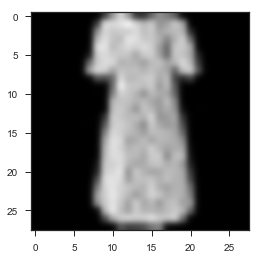

In [55]:
#First thing is read a document from test set and see what is predicted
show_image(140, test_ds_X_rc, test_ds_Y_temp)

In [56]:
#Loading the model and testing it
with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "model.ckpt/")
    print("Model restored.")
    rounded_pred = tf.argmax(logits, 1)
    pred_result = rounded_pred.eval({x: [test_ds_X_shape[140]],keep_prob: 1.0})
    print("Predicted Result:{}".format(label_classes[pred_result[0]]))

INFO:tensorflow:Restoring parameters from model.ckpt/


INFO:tensorflow:Restoring parameters from model.ckpt/


Model restored.
Predicted Result:dress
